# Trabajo Práctico: Predicción de lluvia en Australia.

- Objetivos: Familiarizarse con la biblioteca scikit-learn y las herramientas que brinda para el pre-procesamiento de datos, la implementación de modelos de clasificación y la evaluación de métricas, con TensorFlow para el entrenamiento de redes neuronales y con streamlit y Docker para la puesta en producción del modelo seleccionado como el más adecuado, entre otras.


## Carga de librerias

In [1]:
!pip install tpot
!pip install imbalanced-learn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from math import sqrt
import time
from sklearn.metrics import confusion_matrix
import joblib

from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
)
from sklearn.linear_model import (
    Ridge, RidgeCV, LinearRegression, SGDRegressor,
    ElasticNet, Lasso, LogisticRegression, ElasticNetCV, LassoCV)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    auc, balanced_accuracy_score, log_loss
)

from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, KFold, LeaveOneOut,
    GridSearchCV, RandomizedSearchCV, train_test_split
)



## Carga del dataset

In [3]:
# Cargar el dataset
df = pd.read_csv(r'weatherAUS.csv')

### Elegimos las ciudades

In [4]:
# Obtener los valores únicos de la columna 'Location'
unique_locations = df['Location'].unique()

In [5]:
# Seleccionar aleatoriamente 10 ciudades
selected_cities = np.random.choice(unique_locations, size=10, replace=False)


In [6]:
# Filtrar el DataFrame para quedarse solo con las ciudades seleccionadas
df = df[df['Location'].isin(selected_cities)]

# Mostrar las primeras filas del DataFrame filtrado
df.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
3040,2009-01-01,BadgerysCreek,13.3,34.2,0.0,NaN,NaN,W,61.0,NNE,...,67.0,NaN,1005.6,NaN,NaN,NaN,21.0,NaN,No,No
3041,2009-01-02,BadgerysCreek,14.7,26.1,0.0,NaN,NaN,SE,46.0,SE,...,59.0,54.0,1012.9,1013.5,NaN,NaN,20.7,22.2,No,No
3042,2009-01-03,BadgerysCreek,13.6,22.3,0.0,NaN,NaN,NNE,30.0,ESE,...,57.0,51.0,1021.9,1019.2,NaN,NaN,17.9,21.7,No,No
3043,2009-01-04,BadgerysCreek,17.7,31.2,0.0,NaN,NaN,NE,39.0,NNE,...,62.0,43.0,1018.7,1013.6,NaN,NaN,22.0,30.6,No,No
3044,2009-01-05,BadgerysCreek,15.5,38.8,0.0,NaN,NaN,SW,50.0,NNE,...,67.0,19.0,1013.2,1007.6,NaN,NaN,22.7,37.6,No,No


In [7]:
#Eliminaremos esta columna, ya que vamos a tomar las ubicaciones como si fueran una misma y así simplificar el modelo.
df.drop('Location', axis=1, inplace=True)

In [8]:
nulos_raintomorrow = df["RainTomorrow"].isnull().sum()

print("El Dataset cuenta con " +  str(nulos_raintomorrow) + " Valores nulos en la variable a predecir.")


El Dataset cuenta con 578 Valores nulos en la variable a predecir.


In [9]:
#Eliminamos del Dataset las filas que en la columna RainTomorrow sean nulas, ya que no nos sirve para el modelo.
df = df.dropna(subset=["RainTomorrow"])

# División del conjunto de datos, Train y Test

Dividimos el dataset en train y test antes de imputar nulos para evitar el data leakage. Al hacerlo por fecha, mantenemos la integridad temporal y respetamos el orden cronológico de los eventos. Esto es crucial para series temporales y problemas donde el tiempo importa. Si usáramos una división aleatoria como `train_test_split`, podríamos filtrar datos de prueba en el entrenamiento, lo que llevaría a un modelo sobreajustado que no generaliza bien en datos futuros.

In [117]:
# Convierto la columna 'Date' a tipo datetime
df["Date"] = pd.to_datetime(df["Date"])

# Mostrar la primera y última fecha
primera_fecha = df['Date'].min()
ultima_fecha = df['Date'].max()

print("Primera fecha:", primera_fecha)
print("Última fecha:", ultima_fecha)

# Calcular la fecha que abarque el 80% de los datos
fecha_80porciento = df['Date'].quantile(0.8)

print("Fecha que abarca el 80% de los datos:", fecha_80porciento)


Primera fecha: 2008-02-01 00:00:00
Última fecha: 2017-06-25 00:00:00
Fecha que abarca el 80% de los datos: 2015-12-24 00:00:00


In [118]:
# Dividir los datos en conjuntos de entrenamiento y prueba basados en la fecha
train = df[df['Date'] <= fecha_80porciento]

test = df[df['Date'] > fecha_80porciento]


print("Tamaño del conjunto de entrenamiento:", train.shape)
print("Tamaño del conjunto de prueba:", test.shape)

Tamaño del conjunto de entrenamiento: (21633, 22)
Tamaño del conjunto de prueba: (5405, 22)


Ya que la fecha no aporta nada más de valor, procedemos a eliminarla para reducir un poco más la dimensionalidad y así la complejidad de nuestro modelo.

In [119]:
train = train.drop('Date', axis=1)

test = test.drop('Date', axis=1)

In [120]:
train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
3040,13.3,34.2,0.0,NaN,NaN,W,61.0,NNE,NaN,11.0,...,67.0,NaN,1005.6,NaN,NaN,NaN,21.0,NaN,No,No
3041,14.7,26.1,0.0,NaN,NaN,SE,46.0,SE,SE,7.0,...,59.0,54.0,1012.9,1013.5,NaN,NaN,20.7,22.2,No,No
3042,13.6,22.3,0.0,NaN,NaN,NNE,30.0,ESE,NE,6.0,...,57.0,51.0,1021.9,1019.2,NaN,NaN,17.9,21.7,No,No
3043,17.7,31.2,0.0,NaN,NaN,NE,39.0,NNE,N,9.0,...,62.0,43.0,1018.7,1013.6,NaN,NaN,22.0,30.6,No,No
3044,15.5,38.8,0.0,NaN,NaN,SW,50.0,NNE,W,7.0,...,67.0,19.0,1013.2,1007.6,NaN,NaN,22.7,37.6,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144905,23.4,39.9,0.0,NaN,NaN,ENE,39.0,NNW,NW,15.0,...,44.0,18.0,1005.8,1000.8,NaN,7.0,30.7,38.6,No,No
144906,23.8,30.3,0.0,NaN,NaN,SSE,43.0,ESE,NNE,13.0,...,66.0,63.0,1006.9,1004.9,6.0,5.0,25.7,28.9,No,Yes
144907,23.6,34.6,4.8,NaN,NaN,E,44.0,ESE,ESE,30.0,...,64.0,43.0,1009.7,1007.5,2.0,2.0,26.4,32.2,Yes,No
144909,24.0,38.5,NaN,NaN,NaN,ENE,39.0,ENE,NE,24.0,...,51.0,25.0,1010.6,1005.0,NaN,7.0,29.0,36.5,NaN,No


In [121]:
test

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
5500,14.5,26.2,0.0,NaN,NaN,ENE,31.0,ENE,ENE,4.0,...,66.0,56.0,1018.6,1014.6,NaN,NaN,21.6,24.0,No,No
5501,15.7,29.3,0.0,NaN,NaN,NNE,30.0,NNE,NNE,11.0,...,76.0,83.0,1009.3,1005.5,NaN,NaN,22.0,24.1,No,No
5502,15.6,24.0,0.0,NaN,NaN,SE,37.0,S,ESE,19.0,...,73.0,45.0,1016.8,1018.0,NaN,NaN,17.8,23.1,No,No
5503,14.9,23.4,0.0,NaN,NaN,SE,35.0,S,SE,15.0,...,64.0,51.0,1023.6,1022.6,NaN,NaN,18.9,23.1,No,No
5504,13.1,27.1,0.0,NaN,NaN,E,30.0,SSW,NNE,9.0,...,60.0,39.0,1022.6,1019.8,NaN,NaN,20.5,25.6,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,E,15.0,...,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No
145455,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No


# Visualización de datos Train

Examinaremos los datos para un primer vistazo.

In [122]:
train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
3040,13.3,34.2,0.0,NaN,NaN,W,61.0,NNE,NaN,11.0,...,67.0,NaN,1005.6,NaN,NaN,NaN,21.0,NaN,No,No
3041,14.7,26.1,0.0,NaN,NaN,SE,46.0,SE,SE,7.0,...,59.0,54.0,1012.9,1013.5,NaN,NaN,20.7,22.2,No,No
3042,13.6,22.3,0.0,NaN,NaN,NNE,30.0,ESE,NE,6.0,...,57.0,51.0,1021.9,1019.2,NaN,NaN,17.9,21.7,No,No
3043,17.7,31.2,0.0,NaN,NaN,NE,39.0,NNE,N,9.0,...,62.0,43.0,1018.7,1013.6,NaN,NaN,22.0,30.6,No,No
3044,15.5,38.8,0.0,NaN,NaN,SW,50.0,NNE,W,7.0,...,67.0,19.0,1013.2,1007.6,NaN,NaN,22.7,37.6,No,No


In [123]:
train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

A continuación, examinaremos qué tipos de variables son estas columnas.

In [124]:
train.dtypes

MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

Investiguemos la presencia de valores nulos en los datos.

In [125]:
train.isna().sum()

MinTemp             60
MaxTemp             21
Rainfall           230
Evaporation      13111
Sunshine         14545
WindGustDir       1172
WindGustSpeed     1138
WindDir9am        2019
WindDir3pm         348
WindSpeed9am       141
WindSpeed3pm       118
Humidity9am        177
Humidity3pm        174
Pressure9am       2638
Pressure3pm       2647
Cloud9am         14303
Cloud3pm         14325
Temp9am             91
Temp3pm             85
RainToday          230
RainTomorrow         0
dtype: int64

Los valores faltantes de cada columna los trataremos.

Para concluir nuestra primera inspección, veremos las estadísticas descriptivas del conjunto de datos.

In [126]:
train.describe(include='all')

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,21573.000000,21612.000000,21403.000000,8522.000000,7088.000000,20461,20495.000000,19614,21285,21492.000000,...,21456.000000,21459.000000,18995.000000,18986.000000,7330.000000,7308.000000,21542.000000,21548.000000,21403,21633
unique,NaN,NaN,NaN,NaN,NaN,16,NaN,16,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,NaN,NaN,NaN,NaN,NaN,SSW,NaN,W,S,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,NaN,NaN,NaN,NaN,NaN,1750,NaN,1845,1776,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16767,16942
mean,12.188801,23.355816,2.142868,5.909481,7.428315,NaN,39.255818,NaN,NaN,13.213847,...,70.412798,50.825714,1018.422274,1016.018703,4.178718,4.263820,16.660941,21.829386,NaN,NaN
std,5.543101,6.495816,6.921926,5.923291,3.828132,NaN,14.027117,NaN,NaN,9.041653,...,19.984969,21.705141,7.065033,7.008356,2.962214,2.809965,5.443442,6.373543,NaN,NaN
min,-4.800000,9.000000,0.000000,0.000000,0.000000,NaN,7.000000,NaN,NaN,0.000000,...,0.000000,0.000000,986.700000,985.100000,0.000000,0.000000,-0.200000,7.100000,NaN,NaN
25%,8.100000,18.500000,0.000000,2.400000,4.500000,NaN,30.000000,NaN,NaN,6.000000,...,59.000000,35.000000,1013.700000,1011.200000,1.000000,1.000000,12.600000,17.200000,NaN,NaN
50%,12.000000,22.400000,0.000000,4.400000,8.200000,NaN,37.000000,NaN,NaN,13.000000,...,73.000000,51.000000,1018.500000,1016.100000,5.000000,5.000000,16.500000,20.800000,NaN,NaN
75%,16.400000,27.200000,0.600000,7.600000,10.400000,NaN,48.000000,NaN,NaN,19.000000,...,85.000000,66.000000,1023.300000,1020.800000,7.000000,7.000000,20.400000,25.400000,NaN,NaN


In [127]:
# Información general del dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21633 entries, 3040 to 144910
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        21573 non-null  float64
 1   MaxTemp        21612 non-null  float64
 2   Rainfall       21403 non-null  float64
 3   Evaporation    8522 non-null   float64
 4   Sunshine       7088 non-null   float64
 5   WindGustDir    20461 non-null  object 
 6   WindGustSpeed  20495 non-null  float64
 7   WindDir9am     19614 non-null  object 
 8   WindDir3pm     21285 non-null  object 
 9   WindSpeed9am   21492 non-null  float64
 10  WindSpeed3pm   21515 non-null  float64
 11  Humidity9am    21456 non-null  float64
 12  Humidity3pm    21459 non-null  float64
 13  Pressure9am    18995 non-null  float64
 14  Pressure3pm    18986 non-null  float64
 15  Cloud9am       7330 non-null   float64
 16  Cloud3pm       7308 non-null   float64
 17  Temp9am        21542 non-null  float64
 18  Temp3pm

In [128]:
# Contamos el número total de filas que tengan todos sus valores como nulos
nulas = train.isnull().all(axis=1).sum()
nulas

0

In [129]:
train.count()

MinTemp          21573
MaxTemp          21612
Rainfall         21403
Evaporation       8522
Sunshine          7088
WindGustDir      20461
WindGustSpeed    20495
WindDir9am       19614
WindDir3pm       21285
WindSpeed9am     21492
WindSpeed3pm     21515
Humidity9am      21456
Humidity3pm      21459
Pressure9am      18995
Pressure3pm      18986
Cloud9am          7330
Cloud3pm          7308
Temp9am          21542
Temp3pm          21548
RainToday        21403
RainTomorrow     21633
dtype: int64

# Graficos de Train

### MinTemp

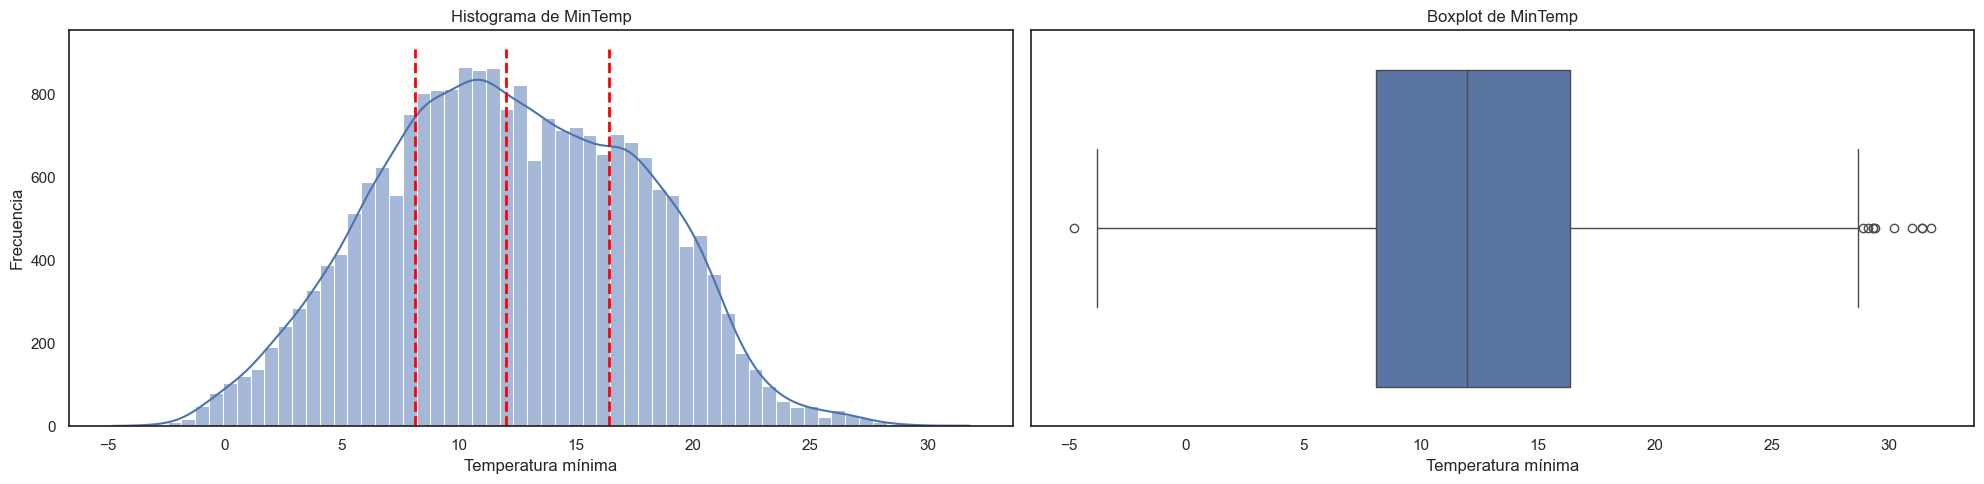

count    21573.000000
mean        12.188801
std          5.543101
min         -4.800000
25%          8.100000
50%         12.000000
75%         16.400000
max         31.800000
Name: MinTemp, dtype: float64

In [130]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['MinTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MinTemp')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['MinTemp'].quantile(0.25)
q2 = train['MinTemp'].quantile(0.5)
q3 = train['MinTemp'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['MinTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MinTemp')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()

train['MinTemp'].describe()

La variable MinTemp posee una distribución normal, predominando una temperatura de 10/12° aproximadamente. La misma, tiene picos de 33, y minimos de -8°, siendo estos casos extremos.

### MaxTemp

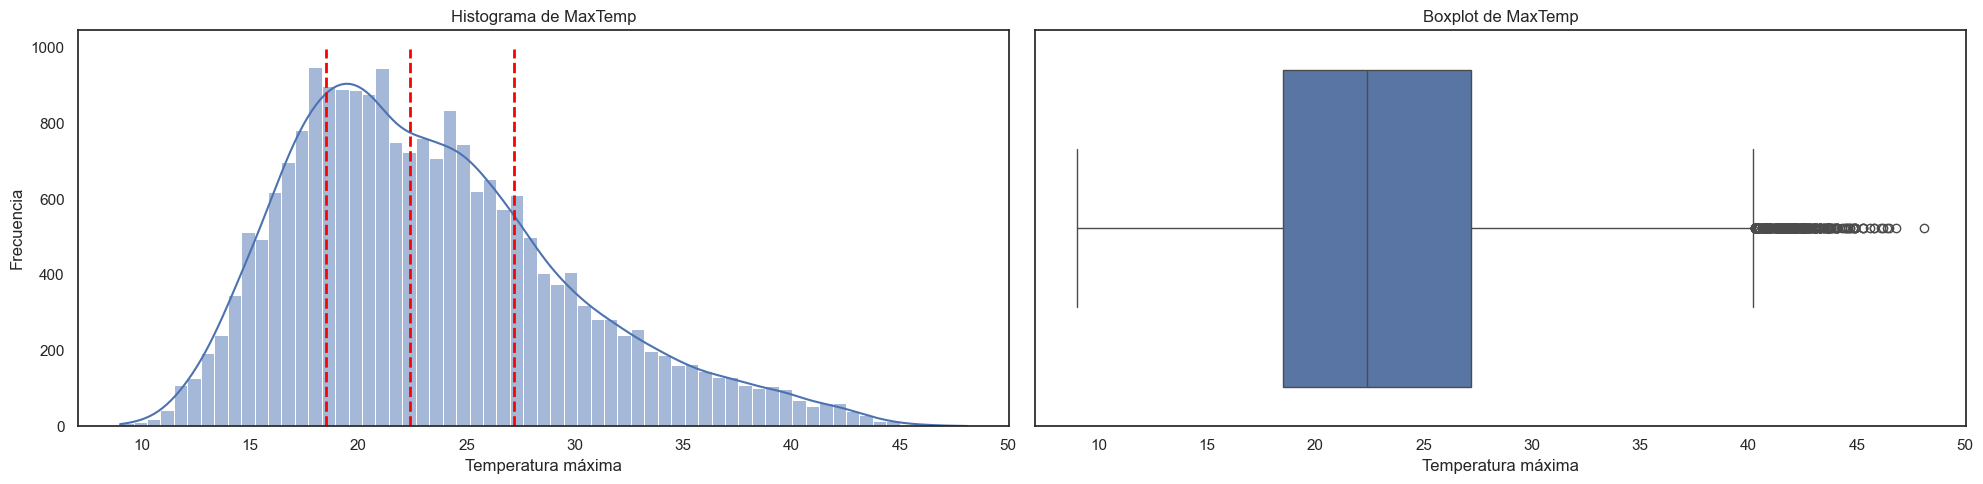

count    21612.000000
mean        23.355816
std          6.495816
min          9.000000
25%         18.500000
50%         22.400000
75%         27.200000
max         48.100000
Name: MaxTemp, dtype: float64

In [131]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['MaxTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MaxTemp')
axs[0].set_xlabel('Temperatura máxima')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['MaxTemp'].quantile(0.25)
q2 = train['MaxTemp'].quantile(0.5)
q3 = train['MaxTemp'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['MaxTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MaxTemp')
axs[1].set_xlabel('Temperatura máxima')

plt.tight_layout()
plt.show()

train['MaxTemp'].describe()


La variable MaxTemp posee una distribución normal con sesgo a la derecha, predominando una temperatura maxima de 21° aproximadamente. La misma, tiene picos de 45° y minimos de 4°, pudiendo considerarse estos mismos como Outliers

### Rainfall

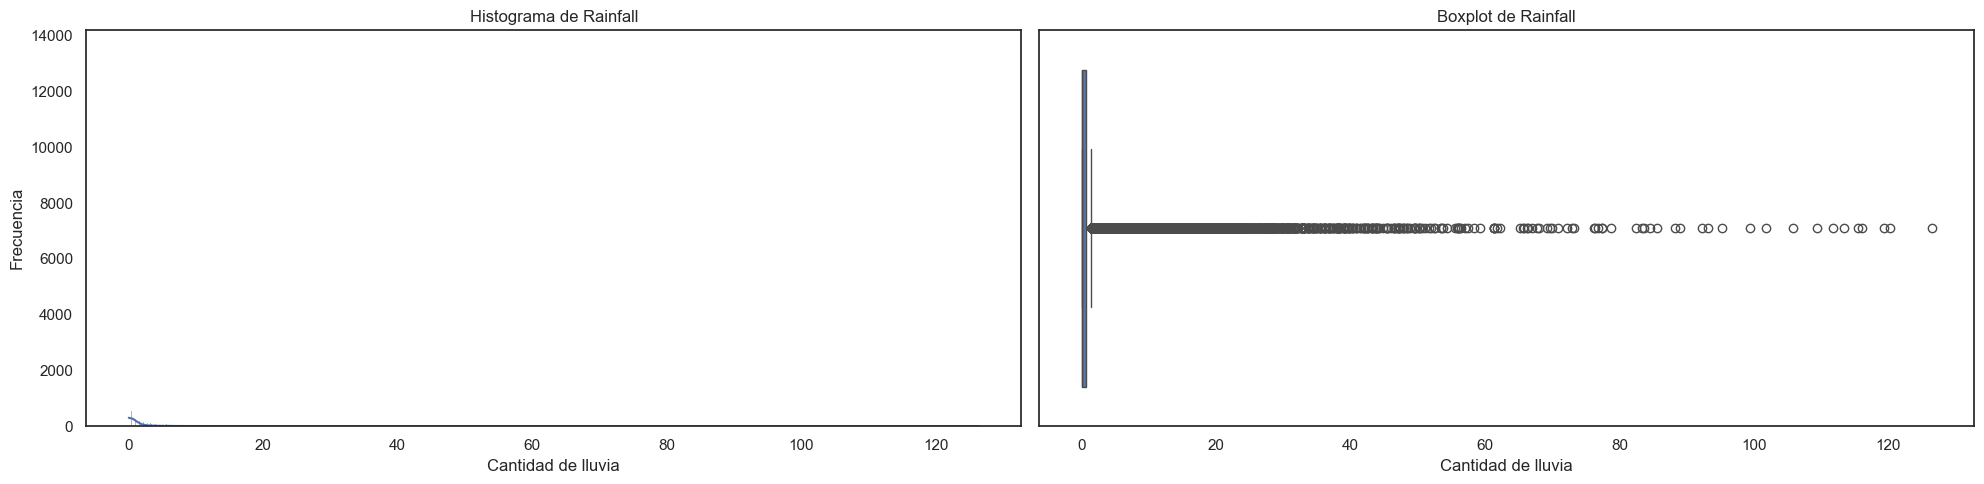

count    21403.000000
mean         2.142868
std          6.921926
min          0.000000
25%          0.000000
50%          0.000000
75%          0.600000
max        126.400000
Name: Rainfall, dtype: float64

In [132]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Cantidad de lluvia')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=train['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Cantidad de lluvia')

plt.tight_layout()
plt.show()

train['Rainfall'].describe()


### Evaporation

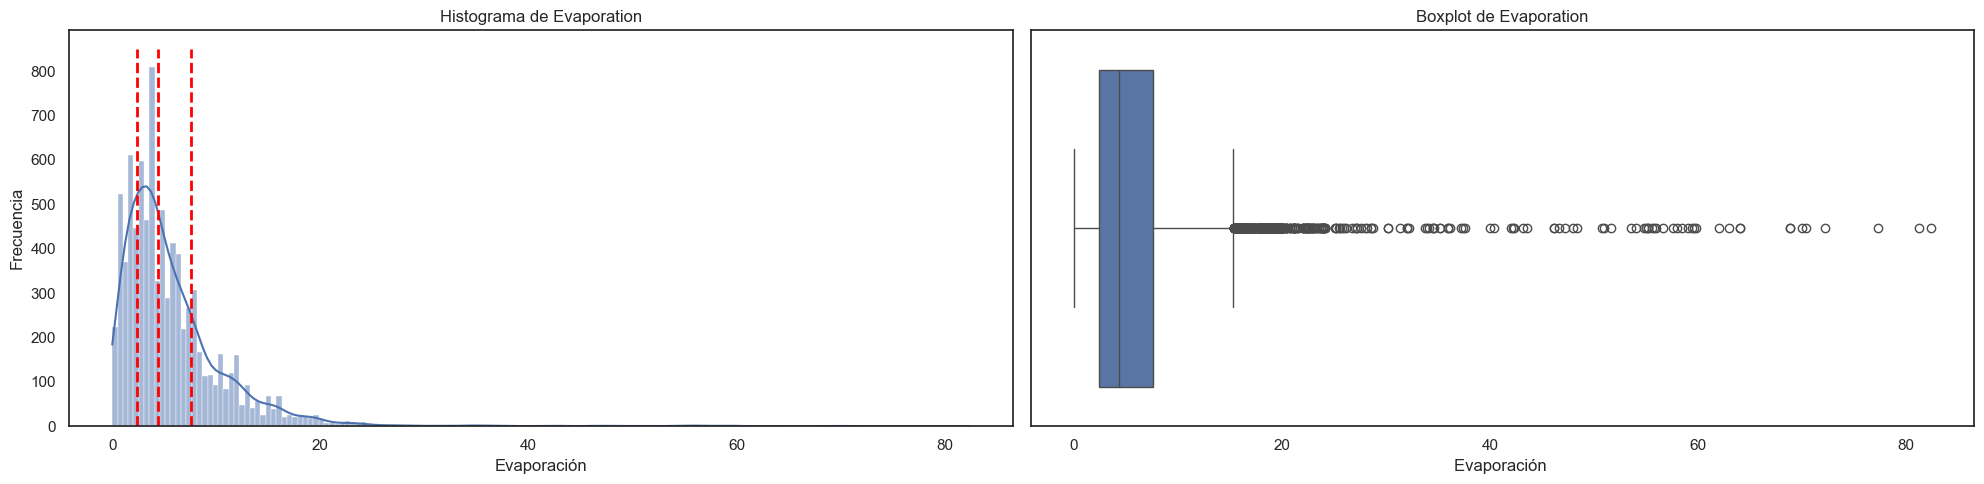

count    8522.000000
mean        5.909481
std         5.923291
min         0.000000
25%         2.400000
50%         4.400000
75%         7.600000
max        82.400000
Name: Evaporation, dtype: float64

In [133]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Evaporation'], kde=True, ax=axs[0])

# Calcular cuartiles
q1 = train['Evaporation'].quantile(0.25)
q2 = train['Evaporation'].quantile(0.5)
q3 = train['Evaporation'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

axs[0].set_title('Histograma de Evaporation')
axs[0].set_xlabel('Evaporación')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=train['Evaporation'], ax=axs[1])
axs[1].set_title('Boxplot de Evaporation')
axs[1].set_xlabel('Evaporación ')

plt.tight_layout()
plt.show()

train['Evaporation'].describe()



Como podemos ver, nuestra variable Evaporation tiene una gran cantidad de Outliers y muy distribuidos unos respectos de otros, con rango entre 15 y 45, los cuales debemos tener en cuenta a la hora del entrenamiento dado que si consideramos quitarlos, podríamos perder gran información valiosa.

### Sunshine

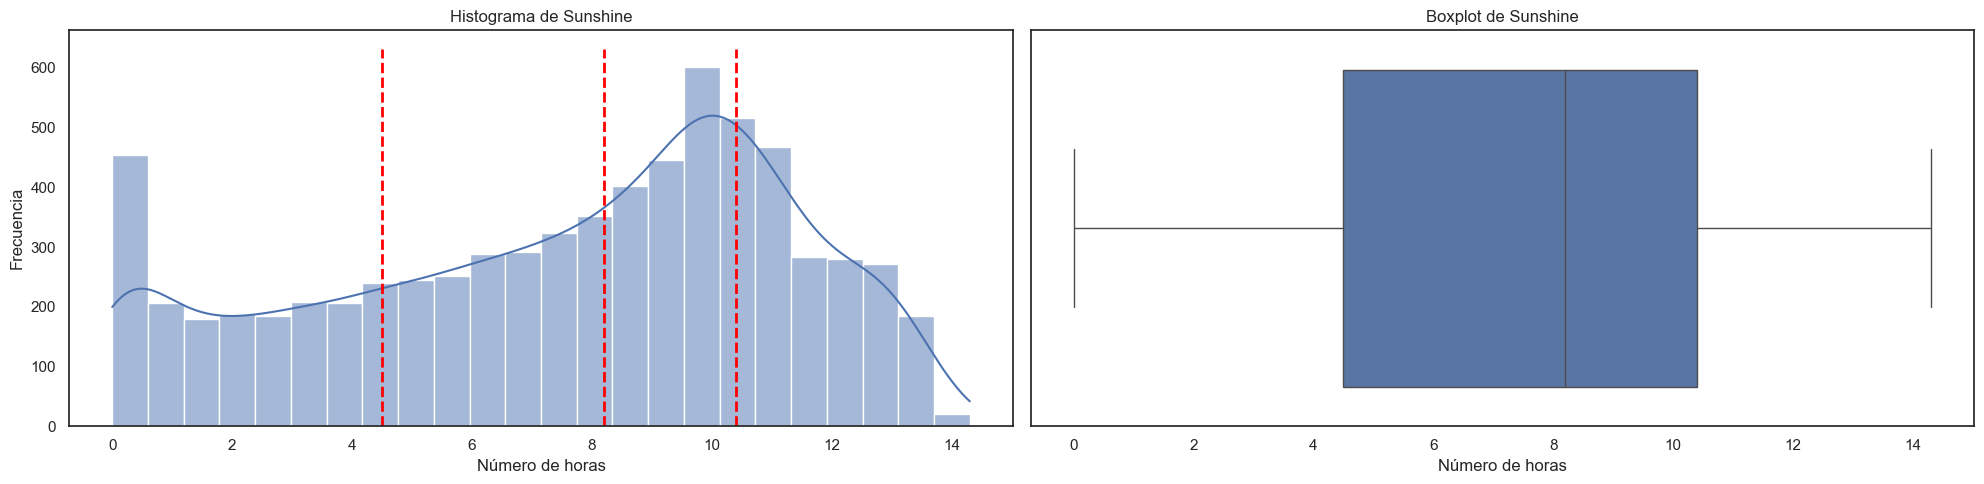

count    7088.000000
mean        7.428315
std         3.828132
min         0.000000
25%         4.500000
50%         8.200000
75%        10.400000
max        14.300000
Name: Sunshine, dtype: float64

In [134]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Sunshine'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Sunshine')
axs[0].set_xlabel('Número de horas')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Sunshine'].quantile(0.25)
q2 = train['Sunshine'].quantile(0.5)
q3 = train['Sunshine'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Sunshine'], ax=axs[1])
axs[1].set_title('Boxplot de Sunshine')
axs[1].set_xlabel('Número de horas')

plt.tight_layout()
plt.show()

train['Sunshine'].describe()

### WindGustDir

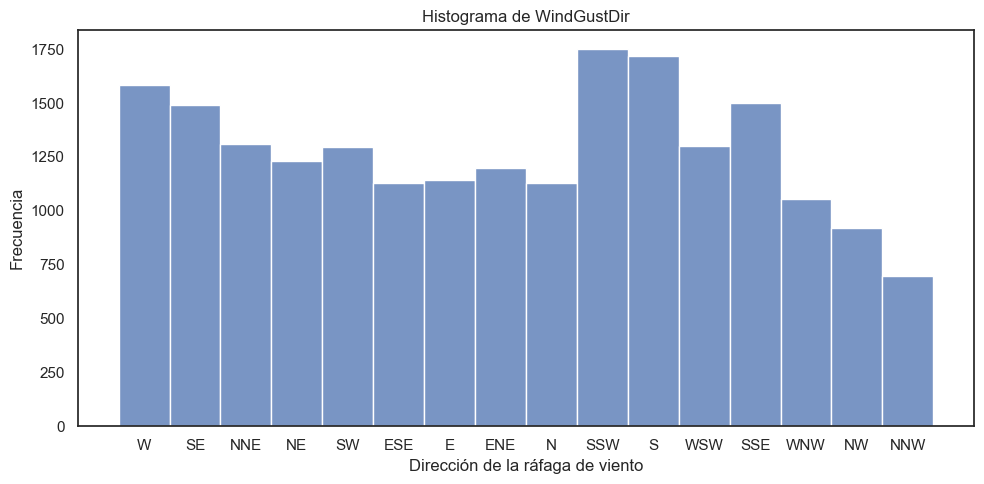

count     20461
unique       16
top         SSW
freq       1750
Name: WindGustDir, dtype: object

In [135]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['WindGustDir'])
axs.set_title('Histograma de WindGustDir')
axs.set_xlabel('Dirección de la ráfaga de viento')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['WindGustDir'].describe()

### WindGustSpeed

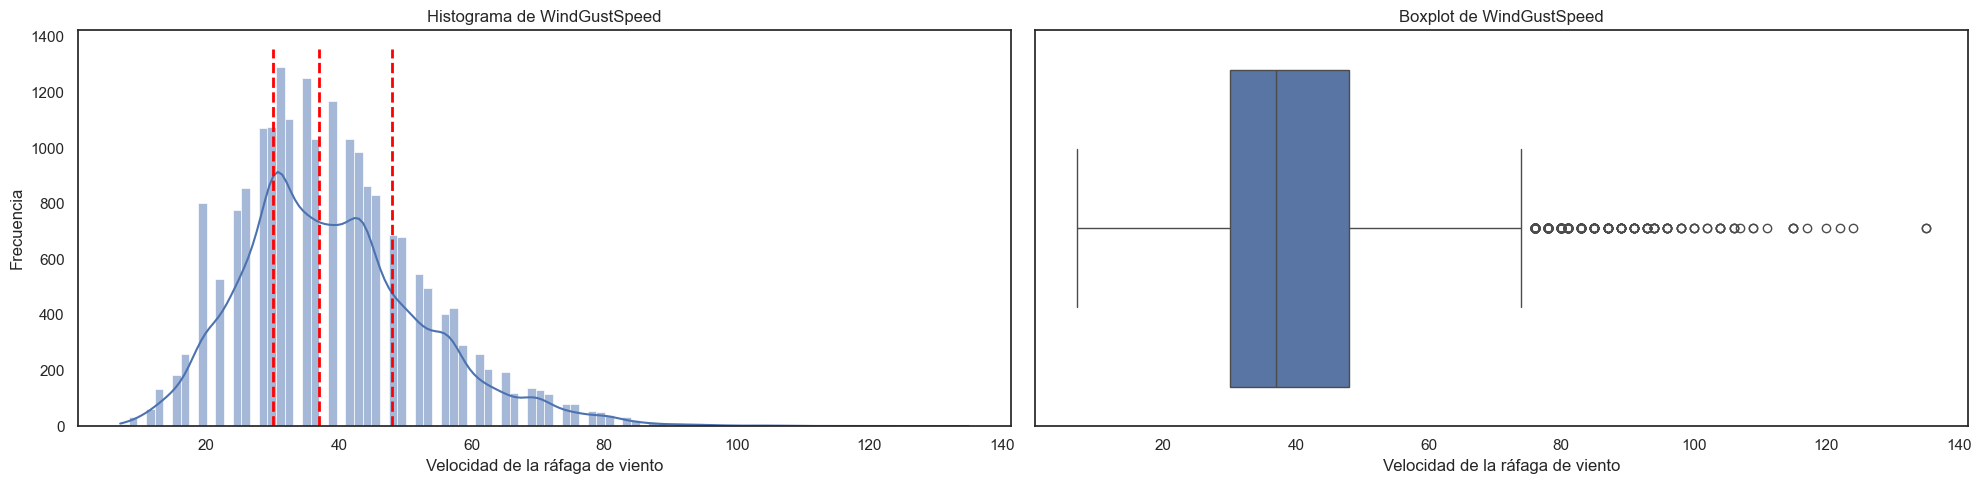

count    20495.000000
mean        39.255818
std         14.027117
min          7.000000
25%         30.000000
50%         37.000000
75%         48.000000
max        135.000000
Name: WindGustSpeed, dtype: float64

In [136]:

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['WindGustSpeed'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindGustSpeed')
axs[0].set_xlabel('Velocidad de la ráfaga de viento')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['WindGustSpeed'].quantile(0.25)
q2 = train['WindGustSpeed'].quantile(0.5)
q3 = train['WindGustSpeed'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['WindGustSpeed'], ax=axs[1])
axs[1].set_title('Boxplot de WindGustSpeed')
axs[1].set_xlabel('Velocidad de la ráfaga de viento')

plt.tight_layout()
plt.show()
train['WindGustSpeed'].describe()

### WindDir9am

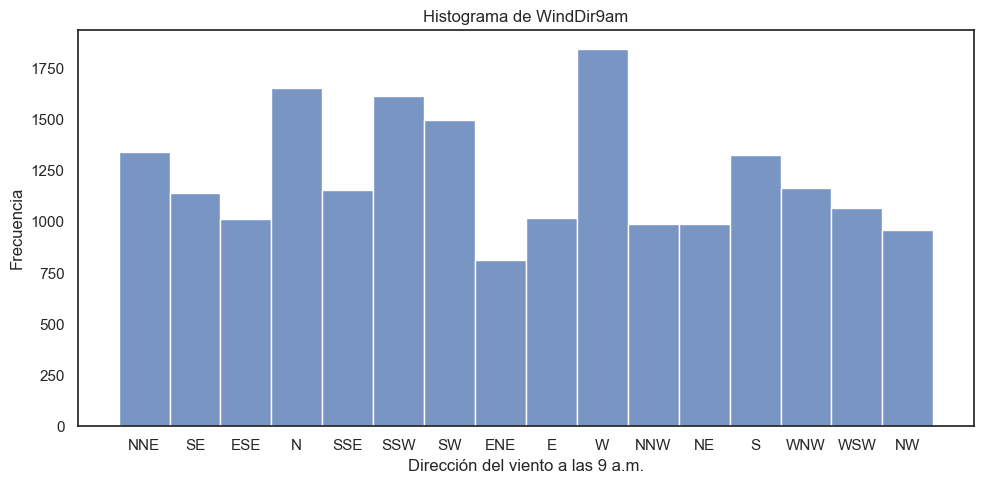

count     19614
unique       16
top           W
freq       1845
Name: WindDir9am, dtype: object

In [137]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['WindDir9am'])
axs.set_title('Histograma de WindDir9am')
axs.set_xlabel('Dirección del viento a las 9 a.m.')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['WindDir9am'].describe()

### WindDir3pm

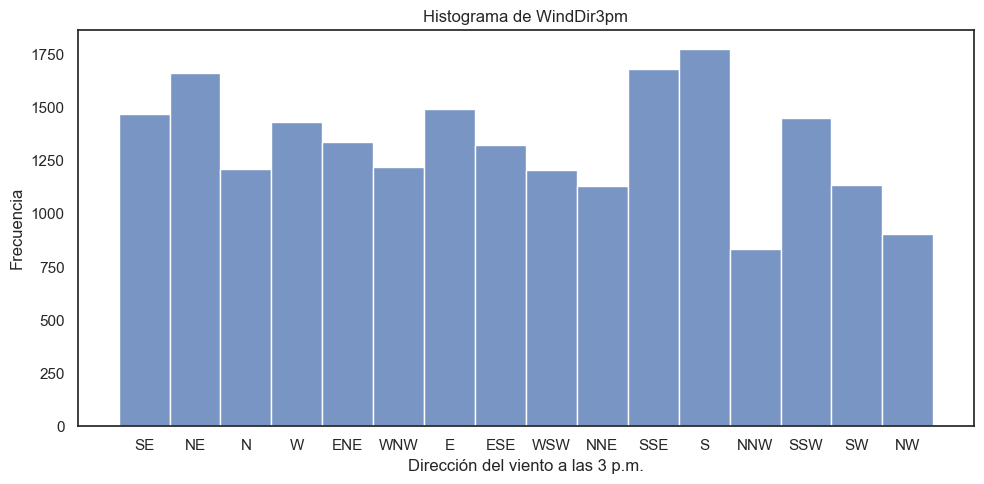

count     21285
unique       16
top           S
freq       1776
Name: WindDir3pm, dtype: object

In [138]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['WindDir3pm'])
axs.set_title('Histograma de WindDir3pm')
axs.set_xlabel('Dirección del viento a las 3 p.m.')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['WindDir3pm'].describe()

### WindSpeed9am

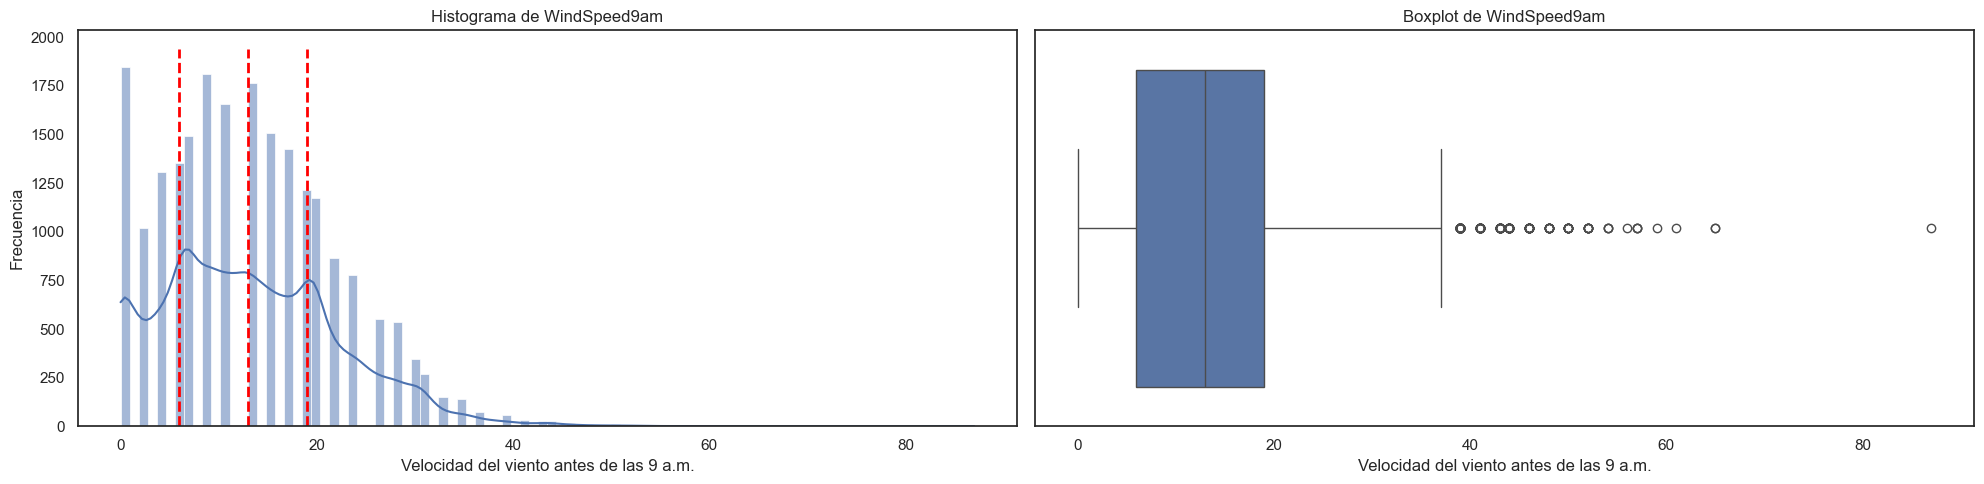

In [139]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['WindSpeed9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed9am')
axs[0].set_xlabel('Velocidad del viento antes de las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['WindSpeed9am'].quantile(0.25)
q2 = train['WindSpeed9am'].quantile(0.5)
q3 = train['WindSpeed9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['WindSpeed9am'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed9am')
axs[1].set_xlabel('Velocidad del viento antes de las 9 a.m.')

plt.tight_layout()
plt.show()


### WindSpeed3pm

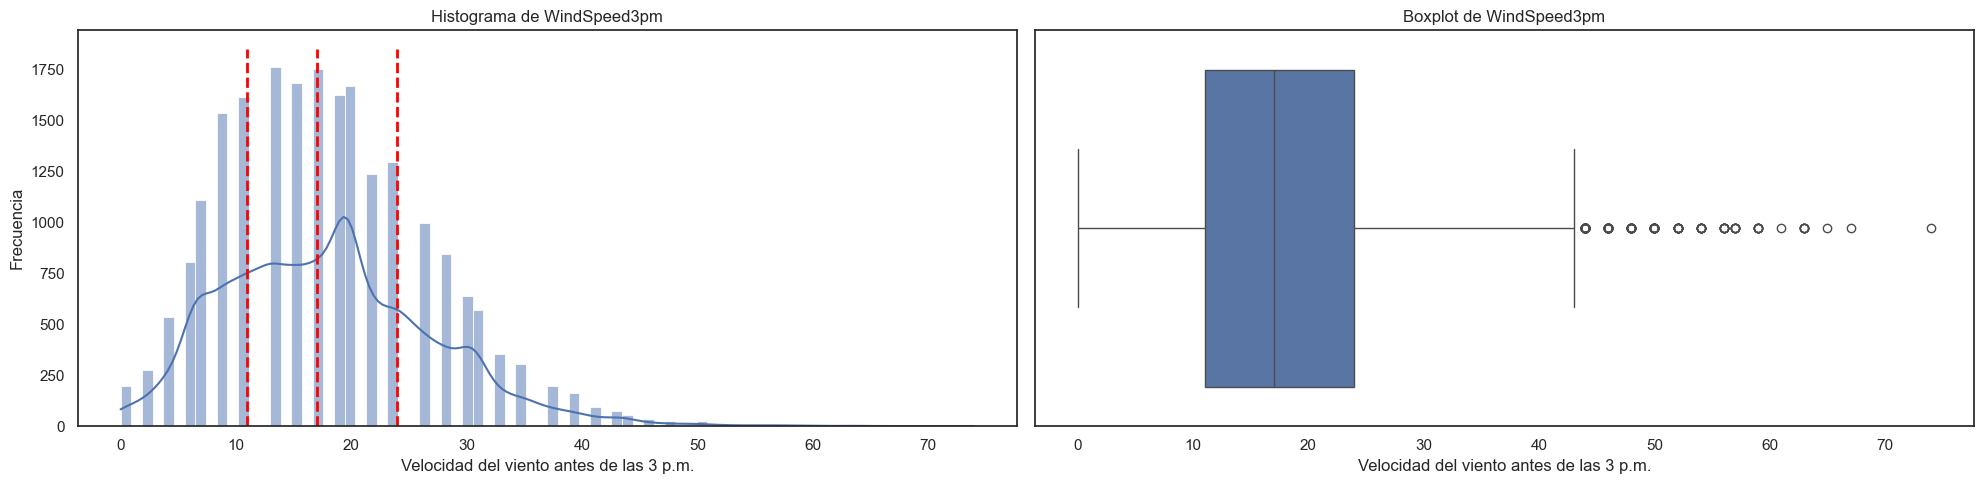

count    21515.000000
mean        17.939902
std          9.043066
min          0.000000
25%         11.000000
50%         17.000000
75%         24.000000
max         74.000000
Name: WindSpeed3pm, dtype: float64

In [140]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['WindSpeed3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed3pm')
axs[0].set_xlabel('Velocidad del viento antes de las 3 p.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = train['WindSpeed3pm'].quantile(0.25)
q2 = train['WindSpeed3pm'].quantile(0.5)
q3 = train['WindSpeed3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['WindSpeed3pm'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed3pm')
axs[1].set_xlabel('Velocidad del viento antes de las 3 p.m.')

plt.tight_layout()
plt.show()

train['WindSpeed3pm'].describe()

### Humidity9am

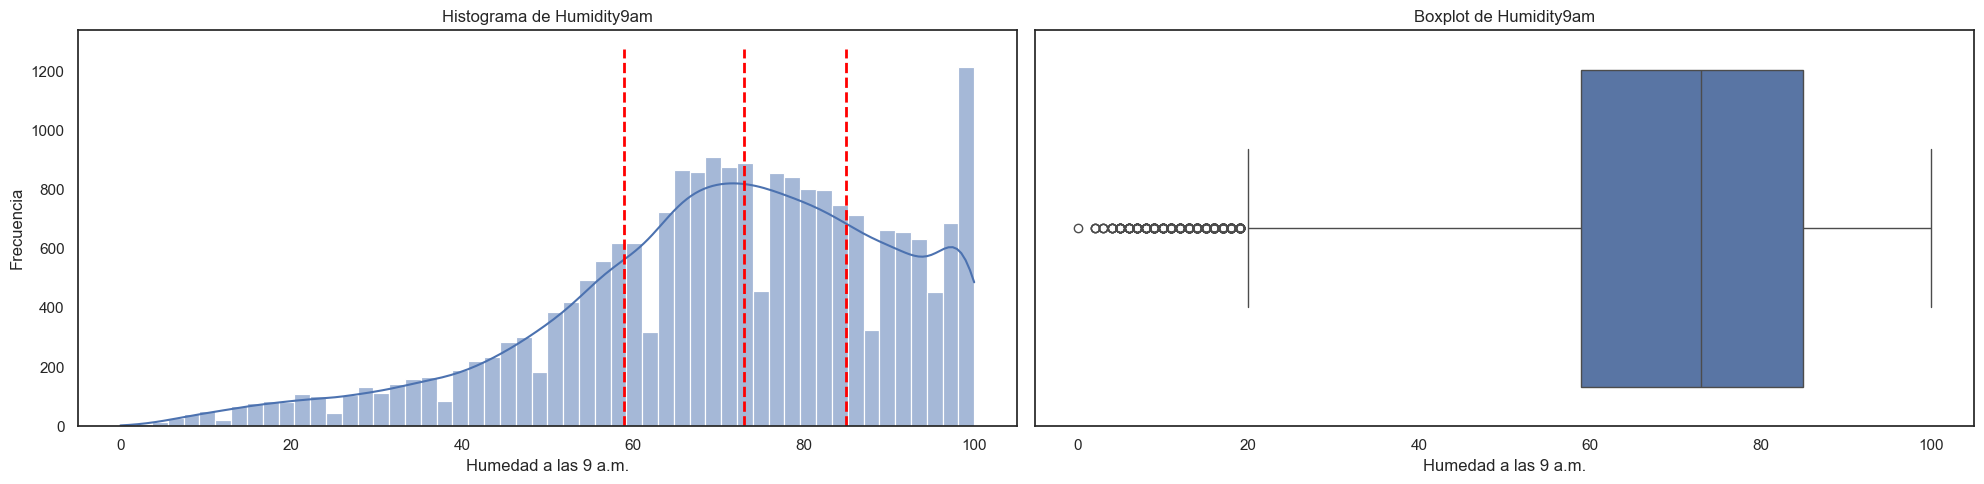

In [141]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Humidity9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Humidity9am')
axs[0].set_xlabel('Humedad a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = train['Humidity9am'].quantile(0.25)
q2 = train['Humidity9am'].quantile(0.5)
q3 = train['Humidity9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Humidity9am'], ax=axs[1])
axs[1].set_title('Boxplot de Humidity9am')
axs[1].set_xlabel('Humedad a las 9 a.m.')

plt.tight_layout()
plt.show()



### Humidity3pm

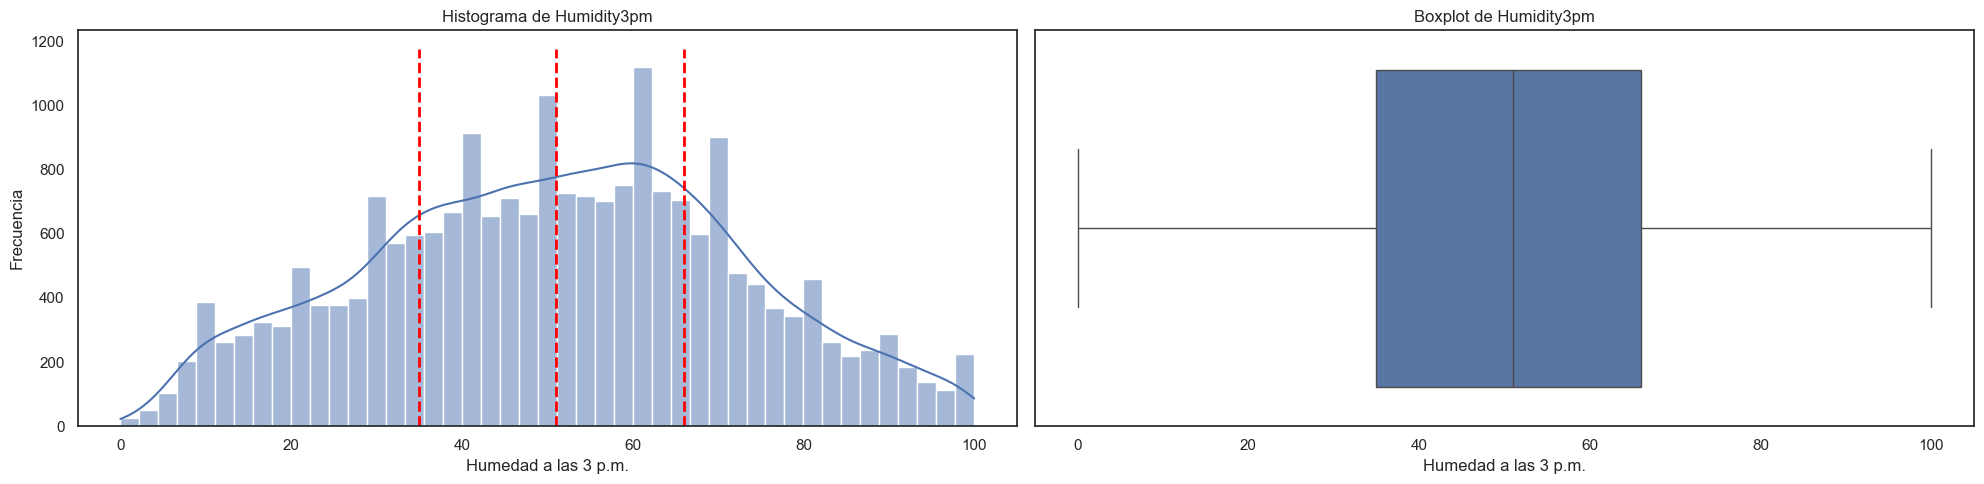

In [142]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Humidity3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Humidity3pm')
axs[0].set_xlabel('Humedad a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = train['Humidity3pm'].quantile(0.25)
q2 = train['Humidity3pm'].quantile(0.5)
q3 = train['Humidity3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Humidity3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Humidity3pm')
axs[1].set_xlabel('Humedad a las 3 p.m.')

plt.tight_layout()
plt.show()


### Pressure9am

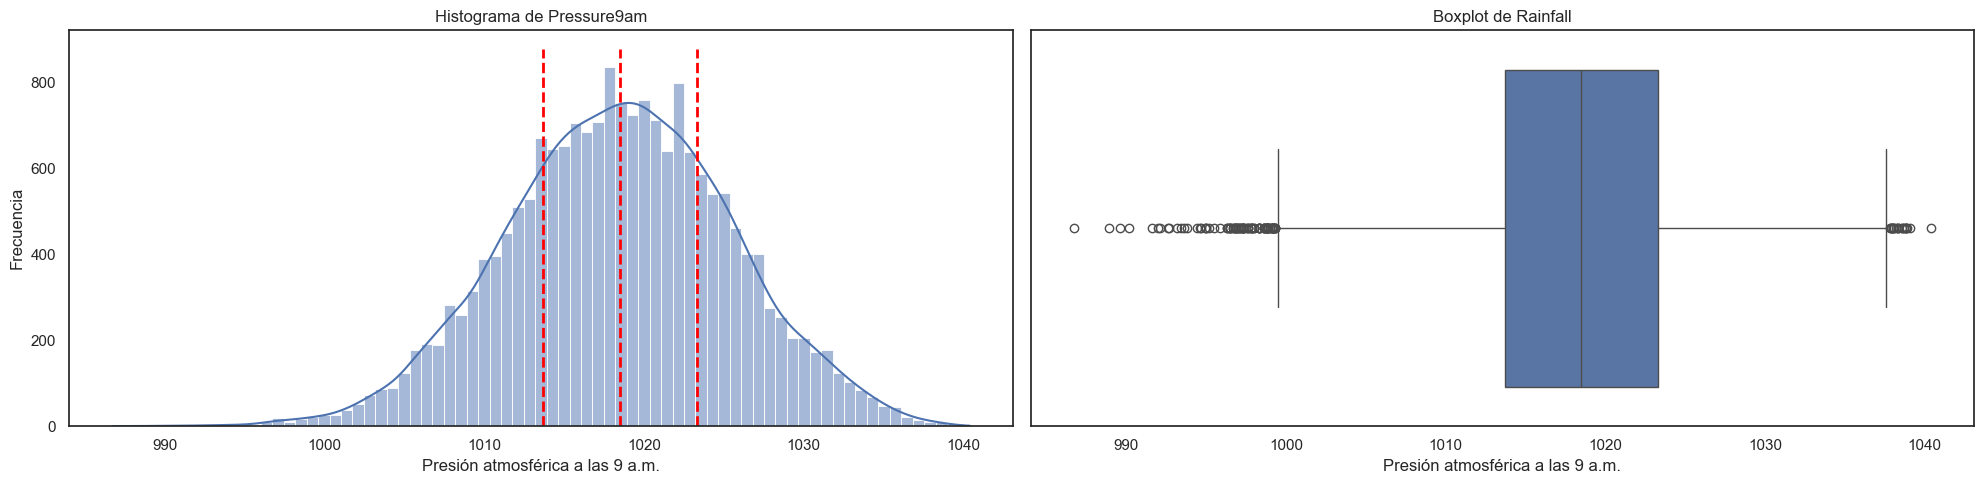

In [143]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Pressure9am'], kde=True, ax=axs[0])

axs[0].set_title('Histograma de Pressure9am')
axs[0].set_xlabel('Presión atmosférica a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')


# Calcular cuartiles
q1 = train['Pressure9am'].quantile(0.25)
q2 = train['Pressure9am'].quantile(0.5)
q3 = train['Pressure9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Pressure9am'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Presión atmosférica a las 9 a.m.')

plt.tight_layout()
plt.show()



### Pressure3pm

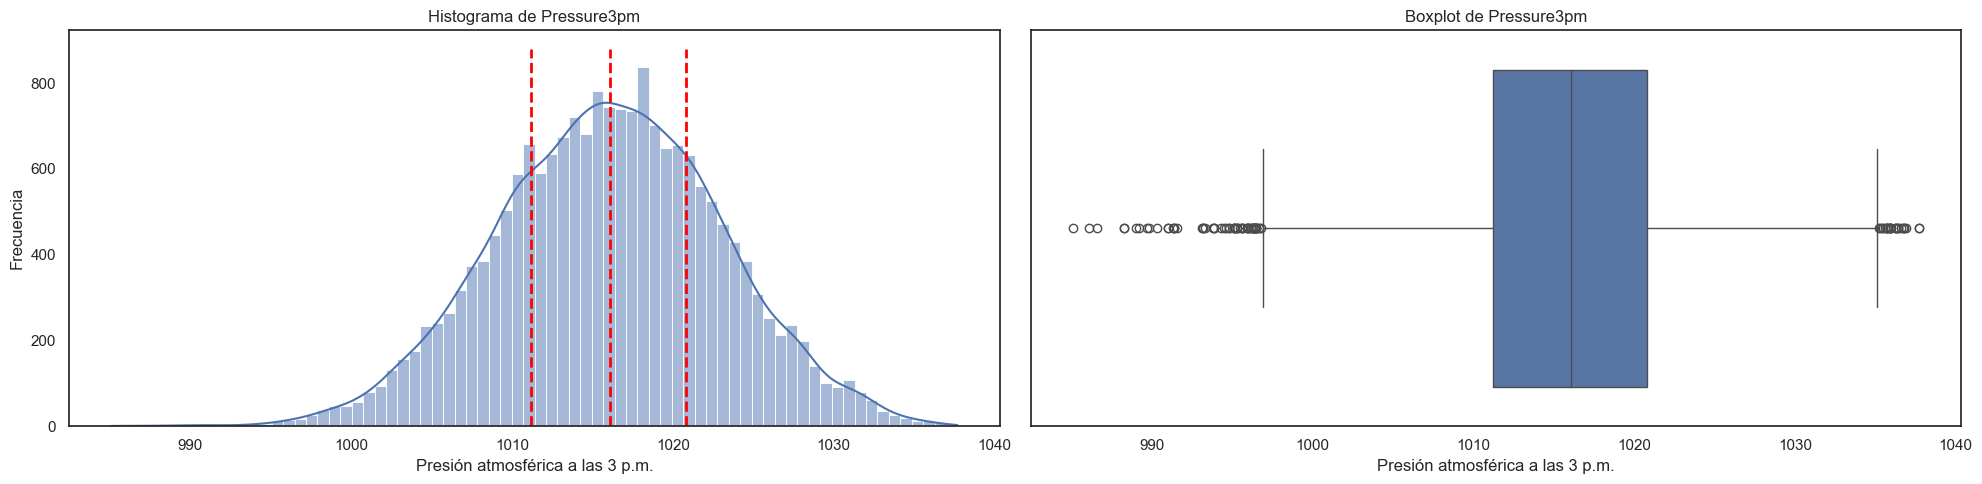

In [144]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Pressure3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Pressure3pm')
axs[0].set_xlabel('Presión atmosférica a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Pressure3pm'].quantile(0.25)
q2 = train['Pressure3pm'].quantile(0.5)
q3 = train['Pressure3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Pressure3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Pressure3pm')
axs[1].set_xlabel('Presión atmosférica a las 3 p.m.')

plt.tight_layout()
plt.show()



### Cloud9am

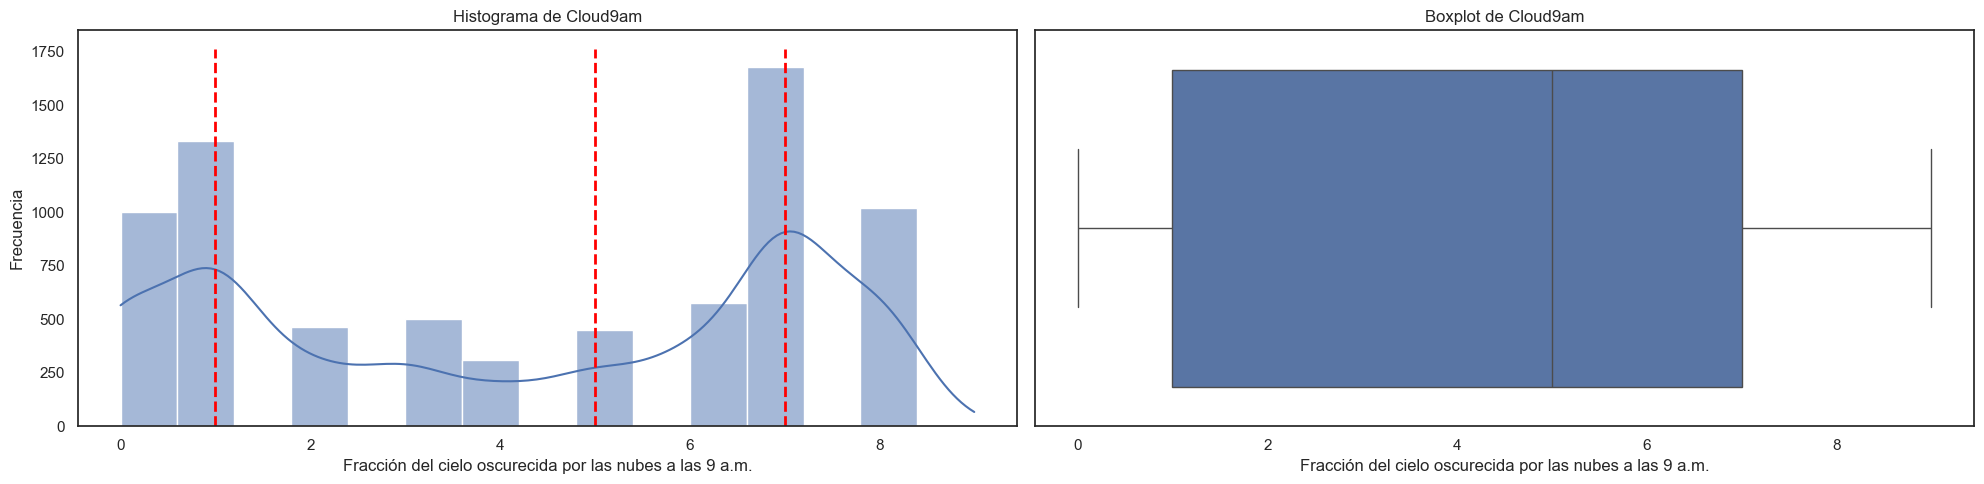

In [145]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))


# Histograma
sns.histplot(train['Cloud9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Cloud9am')
axs[0].set_xlabel('Fracción del cielo oscurecida por las nubes a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Cloud9am'].quantile(0.25)
q2 = train['Cloud9am'].quantile(0.5)
q3 = train['Cloud9am'].quantile(0.75)


# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Cloud9am'], ax=axs[1])
axs[1].set_title('Boxplot de Cloud9am')
axs[1].set_xlabel('Fracción del cielo oscurecida por las nubes a las 9 a.m.')

plt.tight_layout()
plt.show()



### Cloud3pm

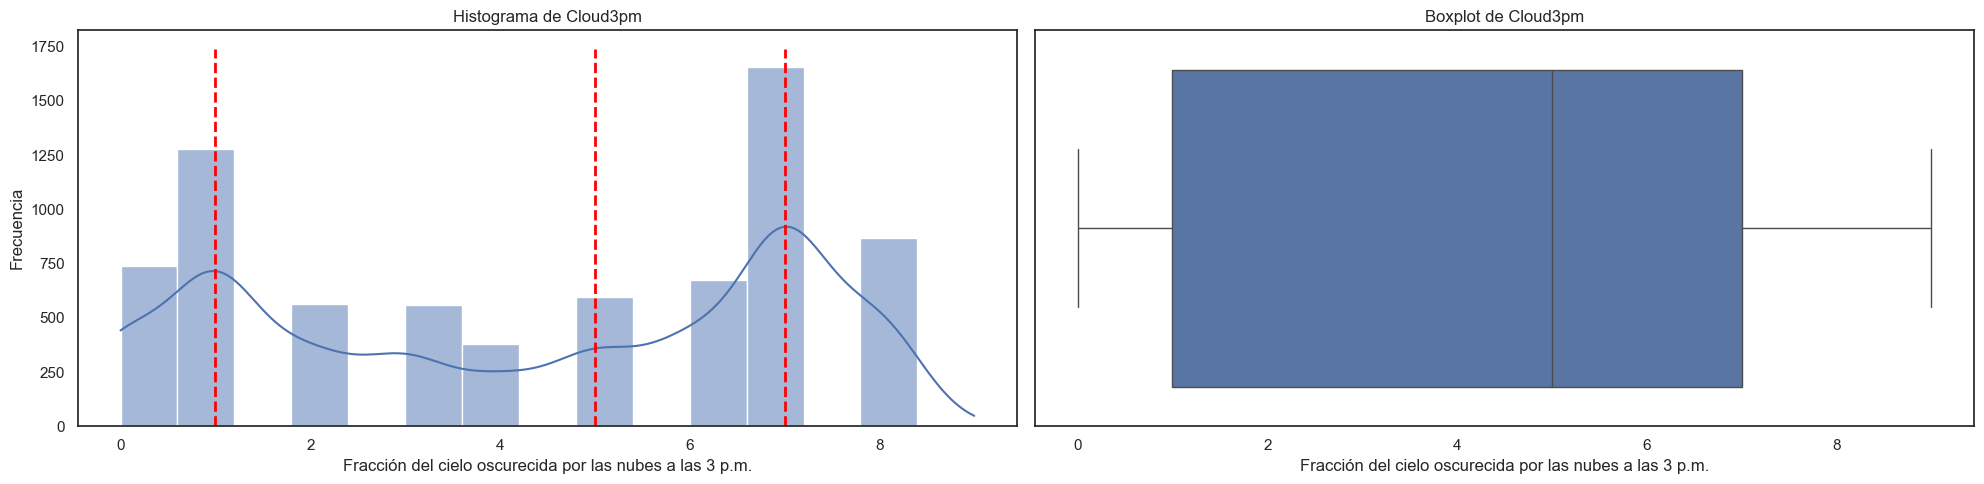

count    7308.000000
mean        4.263820
std         2.809965
min         0.000000
25%         1.000000
50%         5.000000
75%         7.000000
max         9.000000
Name: Cloud3pm, dtype: float64

In [146]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Cloud3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Cloud3pm')
axs[0].set_xlabel('Fracción del cielo oscurecida por las nubes a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Cloud3pm'].quantile(0.25)
q2 = train['Cloud3pm'].quantile(0.5)
q3 = train['Cloud3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Cloud3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Cloud3pm')
axs[1].set_xlabel('Fracción del cielo oscurecida por las nubes a las 3 p.m.')

plt.tight_layout()
plt.show()

train['Cloud3pm'].describe()

### Temp9am

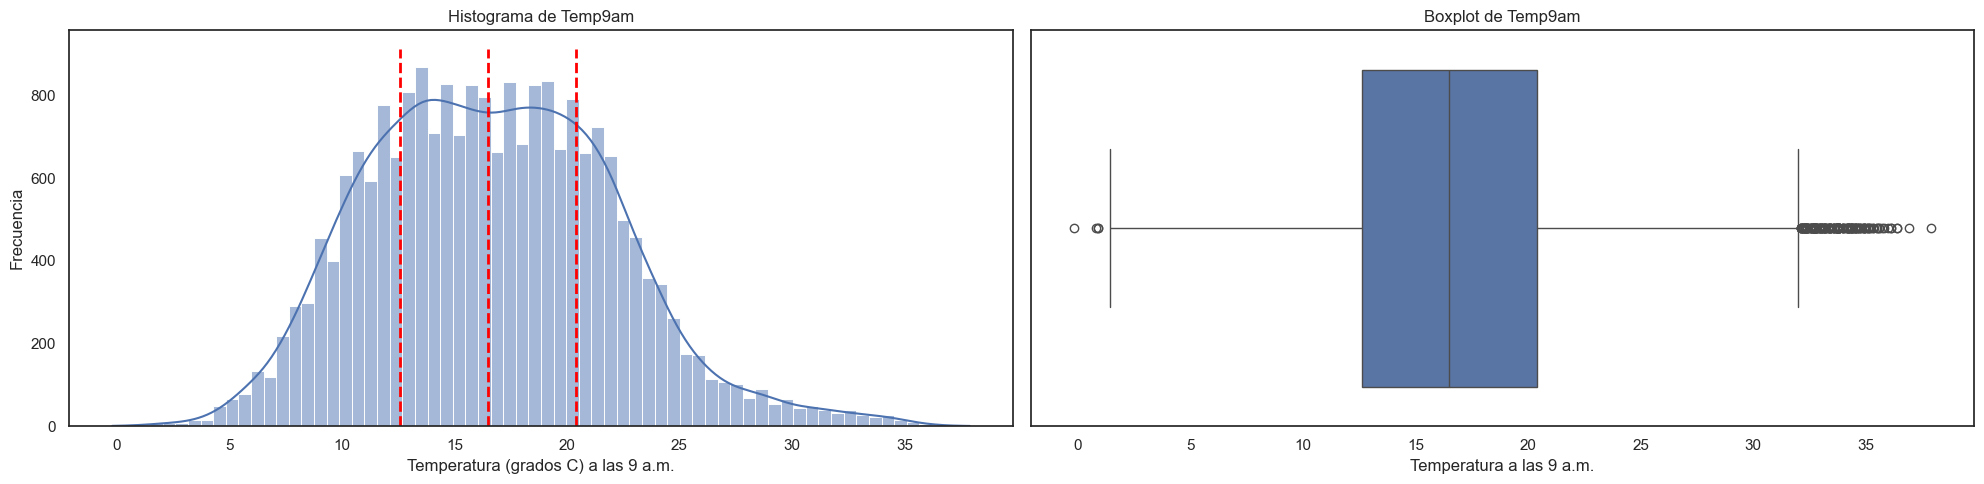

count    21542.000000
mean        16.660941
std          5.443442
min         -0.200000
25%         12.600000
50%         16.500000
75%         20.400000
max         37.900000
Name: Temp9am, dtype: float64

In [147]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(train['Temp9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Temp9am')
axs[0].set_xlabel('Temperatura (grados C) a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Temp9am'].quantile(0.25)
q2 = train['Temp9am'].quantile(0.5)
q3 = train['Temp9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Temp9am'], ax=axs[1])
axs[1].set_title('Boxplot de Temp9am')
axs[1].set_xlabel('Temperatura a las 9 a.m.')

plt.tight_layout()
plt.show()

train['Temp9am'].describe()

### Temp3pm

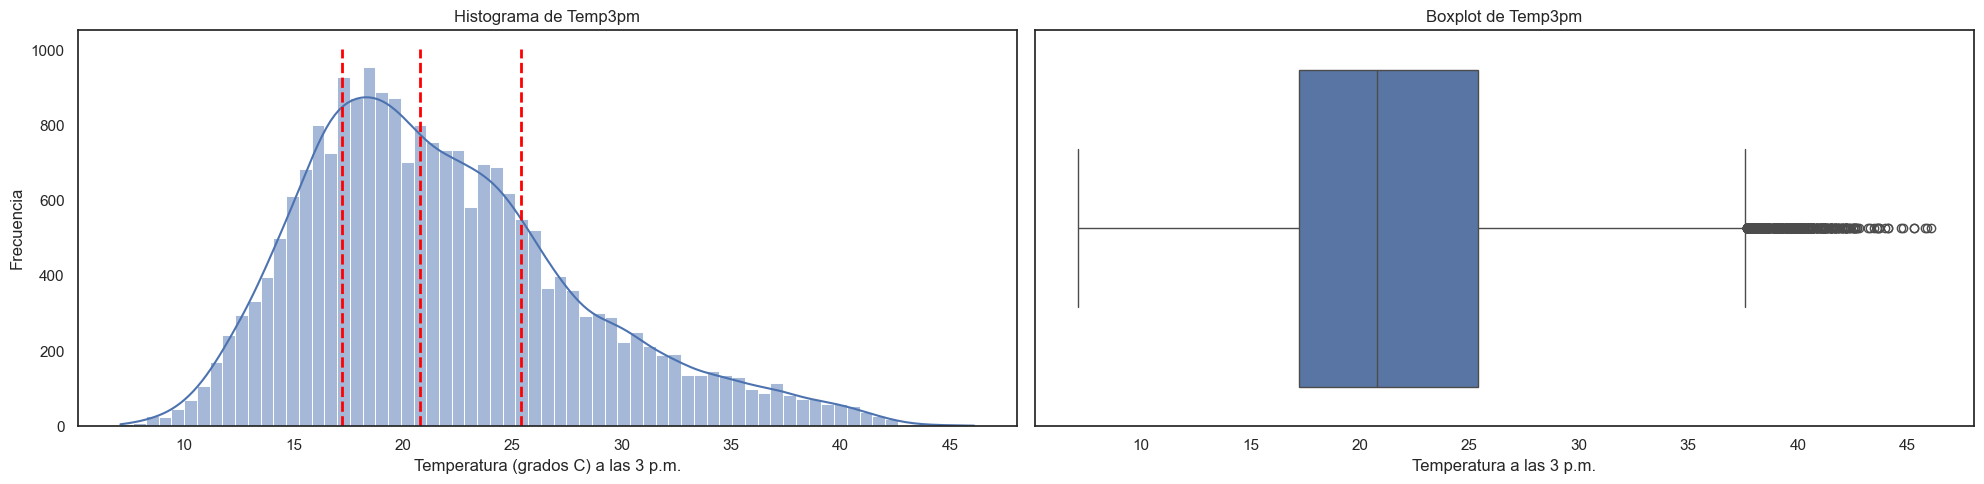

count    21548.000000
mean        21.829386
std          6.373543
min          7.100000
25%         17.200000
50%         20.800000
75%         25.400000
max         46.100000
Name: Temp3pm, dtype: float64

In [148]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))


# Histograma
sns.histplot(train['Temp3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Temp3pm')
axs[0].set_xlabel('Temperatura (grados C) a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = train['Temp3pm'].quantile(0.25)
q2 = train['Temp3pm'].quantile(0.5)
q3 = train['Temp3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=train['Temp3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Temp3pm')
axs[1].set_xlabel('Temperatura a las 3 p.m.')

plt.tight_layout()
plt.show()

train['Temp3pm'].describe()

### RainToday

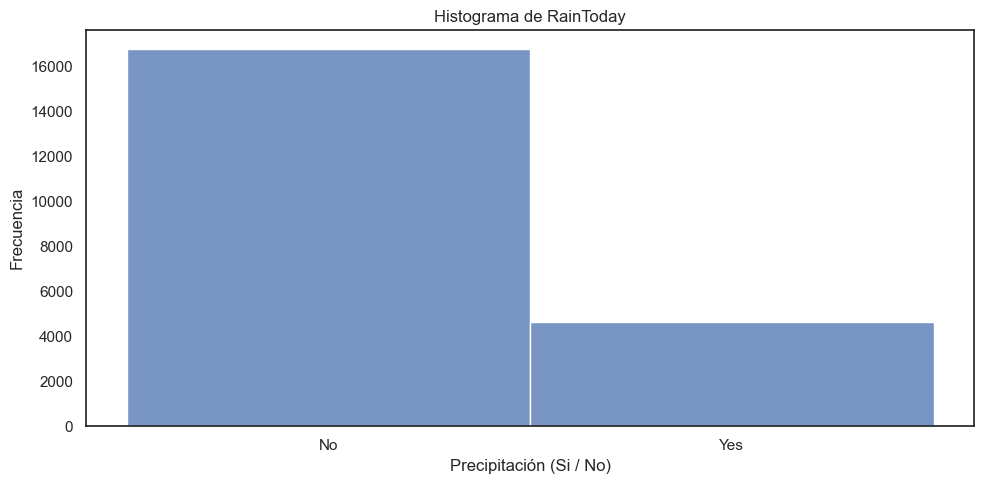

count     21403
unique        2
top          No
freq      16767
Name: RainToday, dtype: object

In [149]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['RainToday'])
axs.set_title('Histograma de RainToday')
axs.set_xlabel('Precipitación (Si / No)')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['RainToday'].describe()

### RainTomorrow

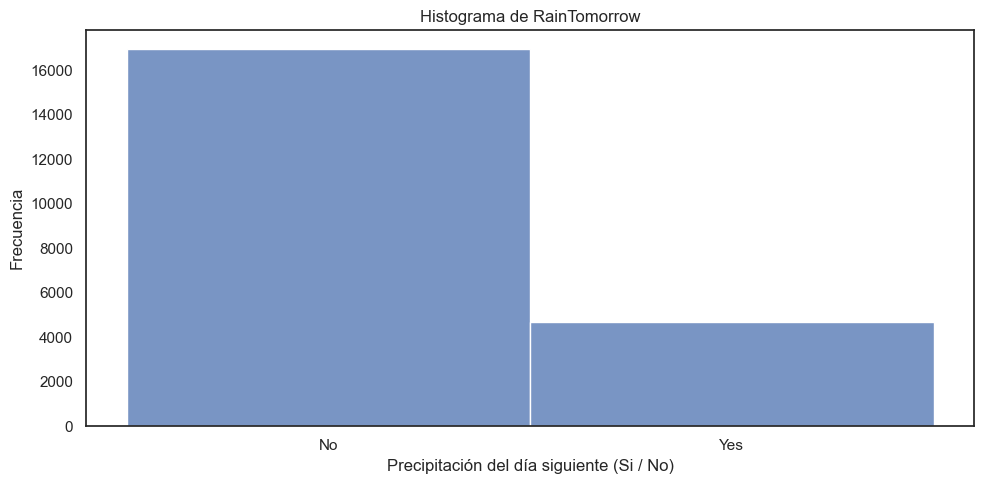

count     21633
unique        2
top          No
freq      16942
Name: RainTomorrow, dtype: object

In [150]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(train['RainTomorrow'])
axs.set_title('Histograma de RainTomorrow')
axs.set_xlabel('Precipitación del día siguiente (Si / No)')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

train['RainTomorrow'].describe()

### Analisis y observaciones luego de la vizualisacion de los datos

Las siguientes caracteristicas presentan valores atípicos: , **MinTemp**, **MaxTemp**, **Rainfall**, **Evaporation**, **WindGustSpeed**, **WindSpeed9am**, **WindSpeed3pm**, **Humidity9am**, **Pressure9am**, **Pressure3pm**, **Temp9am** y **Temp3pm**.

Los valores atípicos pueden sesgar los parámetros del modelo al desviar la línea de regresión, afectando la relación general entre las variables. Podemos optar por tratarlos o no. Si decidimos tratarlos, debemos hacer una excepción con la columna RainTomorrow, que es la variable objetivo, y limitar la eliminación de outliers a un máximo del 10% del total de datos para evitar la pérdida de información valiosa y sesgar los resultados del modelo.

- Date: Fecha de observación.

        Debemos eliminarla porque no contiene información relevante.
        
- Location: El nombre de la ubicación de la estación meteorológica.

        Debemos descartar todas las ubicaciones que no nos interesen y luego las restantes asumirlas como una misma y única, para poder posteriormente eliminar Location y reducir la dimensionalidad para un modelo más simple.

- MinTemp: La temperatura mínima (°C).
- MaxTemp: La temperatura máxima (°C).

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la temperatura promedio durante el día (PromTemp = MaxTemp - MinTemp)

- Rainfall: La cantidad de lluvia registrada durante el día (mm).
- Evaporation: La evaporación del recipiente Clase A (mm) en el período de 24 horas a las 9 a.m.
- Sunshine: El número de horas de sol brillante en el día.
- WindGustDir: La dirección de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche.
- WindGustSpeed: La velocidad (km/h) de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche.
- WindDir9am: Dirección del viento a las 9 a.m.
- WindDir3pm: Dirección del viento a las 3 p.m.
- WindSpeed9am: Velocidad del viento (km/h) promediada de las 9 a.m.
- WindSpeed3pm: Velocidad del viento (km/h) promediada de las 3 p.m.
- Humidity9am: Humedad (porcentaje) a las 9 a.m.
- Humidity3pm: Humedad (porcentaje) a las 3 p.m.

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la diferencia de humedad (ΔHumidity = Humidity3pm - Humidity9am)

- Pressure9am: La presión atmosférica (hPa) a las 9 a. m.
- Pressure3pm: La presión atmosférica (hPa) a las 3 p. m.

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la diferencia de presión atmosférica (ΔPressure = Pressure3pm - Pressure9am)

- Cloud9am: Fracción del cielo oscurecida por las nubes a las 9 a.m. Esto se mide en "oktas", que son una unidad de octavos. Registra cuantos
- Cloud3pm: Fracción del cielo oscurecida por las nubes a las 3 p.m. Esto se mide en "oktas", que son una unidad de octavos. Registra cuantos
- Temp9am: Temperatura (grados C) a las 9 a.m.
- Temp3pm: Temperatura (grados C) a las 3 p.m.
- RainToday: Booleano: 1 si la precipitación (mm) en las 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0
- RainTomorrow: Booleano: 1 si la precipitación (mm) en las siguientes 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0

### Desbalance
El dataset está desbalanceado en la variable objetivo RainTomorrow. Hay una predominancia de la clase "No", lo que sugiere que la mayoría de los días no llovió. Esto es relevante porque entrenar un modelo en un dataset desbalanceado puede llevar a que el modelo se sesgue hacia la clase mayoritaria, afectando su capacidad de predecir correctamente la clase minoritaria ("Yes").

# Manejo de datos faltantes

**Datos numéricos:** Usaremos dos enfoques diferentes para rellenar los datos faltantes en las variables numéricas. Para las columnas con distribuciones no bimodales, utilizaremos la mediana, ya que no se ve influenciada por valores atípicos y es más robusta en conjuntos de datos con valores extremos. Para las columnas detectadas con distribuciones bimodales, emplearemos un imputador basado en KNN (`KNNImputer`), que aprovecha las relaciones entre características para realizar una imputación más informada y adecuada.

**Datos categóricos:** Usaremos la moda para rellenar los datos faltantes en las variables categóricas. La moda representa la categoría más frecuente y asume que los valores faltantes pertenecen a esta categoría, proporcionando una solución sencilla pero efectiva cuando no hay más información disponible.

### Completado de datos de Train

Rellenamos los datos faltantes con la moda para los categoricos y con la mediana para los numericos

In [151]:

# Identificar columnas numéricas y categóricas
numeric_cols = train.select_dtypes(include=np.number).columns
categorical_cols = train.select_dtypes(include='object').columns


In [152]:

from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture
# Identificar automáticamente columnas bimodales o problemáticas
bimodal_numeric_cols = []
non_bimodal_numeric_cols = []

for col in numeric_cols:
    data = train[col].dropna()  # Eliminar valores faltantes para análisis
    # Ajustar un modelo de mezcla gaussiana (2 componentes para detectar bimodalidad)
    gm = GaussianMixture(n_components=2, random_state=42)
    gm.fit(data.values.reshape(-1, 1))
    
    # Calcular la probabilidad de que sea bimodal (diferencia entre las medias de componentes)
    means = np.sort(gm.means_.flatten())  # Obtener las medias
    diff = abs(means[1] - means[0])  # Diferencia entre medias
    if diff > 0.5 * data.std():  # Umbral ajustable
        bimodal_numeric_cols.append(col)
    else:
        non_bimodal_numeric_cols.append(col)

# Imprimir columnas detectadas
print("Columnas con distribuciones bimodales o problemáticas:", bimodal_numeric_cols)
print("Columnas con distribuciones no bimodales:", non_bimodal_numeric_cols)


Columnas con distribuciones bimodales o problemáticas: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
Columnas con distribuciones no bimodales: []


In [153]:

# Separar columnas para imputación
median_impute_cols = non_bimodal_numeric_cols

In [154]:

# Imputación para columnas numéricas
# 1. Usar la mediana para las columnas que no son bimodales
train[median_impute_cols] = train[median_impute_cols].fillna(train[median_impute_cols].median())


In [155]:
from sklearn.impute import KNNImputer

# 2. Usar KNNImputer para las columnas numéricas bimodales
knn_imputer = KNNImputer(n_neighbors=5)
train[bimodal_numeric_cols] = knn_imputer.fit_transform(train[bimodal_numeric_cols])

# Imputación para columnas categóricas
# Usar la moda para las columnas categóricas
train[categorical_cols] = train[categorical_cols].fillna(train[categorical_cols].mode().iloc[0])


In [156]:

# Verificar valores faltantes restantes
print("Valores faltantes después de la imputación:")
print(train.isnull().sum())

Valores faltantes después de la imputación:
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


In [157]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']].isnull().sum()

WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

In [158]:
columns_to_check = [col for col in train.columns if col not in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]
train[columns_to_check].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

### Completado de datos de Test

Vemos que si hay datos faltantes, por lo tanto, rellenamos los datos faltantes con la moda para los categoricos y con la mediana para los numericos

In [159]:
# Identificar columnas numéricas y categóricas en el conjunto de prueba
numeric_cols_test = test.select_dtypes(include=np.number).columns
categorical_cols_test = test.select_dtypes(include='object').columns

# Identificar automáticamente columnas bimodales o problemáticas en el conjunto de prueba
bimodal_numeric_cols_test = []
non_bimodal_numeric_cols_test = []


In [160]:

for col in numeric_cols_test:
    data = test[col].dropna()  # Eliminar valores faltantes para análisis
    if len(data) > 1:  # Asegurarse de tener suficientes datos para el análisis
        gm = GaussianMixture(n_components=2, random_state=42)
        gm.fit(data.values.reshape(-1, 1))
        
        # Calcular la probabilidad de que sea bimodal (diferencia entre las medias de componentes)
        means = np.sort(gm.means_.flatten())  # Obtener las medias
        diff = abs(means[1] - means[0])  # Diferencia entre medias
        if diff > 0.5 * data.std():  # Umbral ajustable
            bimodal_numeric_cols_test.append(col)
        else:
            non_bimodal_numeric_cols_test.append(col)

# Imprimir columnas detectadas
print("Columnas con distribuciones bimodales o problemáticas en test:", bimodal_numeric_cols_test)
print("Columnas con distribuciones no bimodales en test:", non_bimodal_numeric_cols_test)


Columnas con distribuciones bimodales o problemáticas en test: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
Columnas con distribuciones no bimodales en test: []


In [161]:

# Separar columnas para imputación
median_impute_cols_test = non_bimodal_numeric_cols_test

# Imputación para columnas numéricas
# 1. Usar la mediana de `train` para las columnas que no son bimodales
test[median_impute_cols_test] = test[median_impute_cols_test].fillna(train[median_impute_cols_test].median())


In [162]:

# 2. Usar KNNImputer para las columnas numéricas bimodales
if bimodal_numeric_cols_test:  # Evitar errores si no hay columnas bimodales
    knn_imputer_test = KNNImputer(n_neighbors=5)
    test[bimodal_numeric_cols_test] = knn_imputer_test.fit_transform(test[bimodal_numeric_cols_test])

# Imputación para columnas categóricas
# Usar la moda de `train` para las columnas categóricas
test[categorical_cols_test] = test[categorical_cols_test].fillna(train[categorical_cols].mode().iloc[0])

# Verificar valores faltantes restantes
print("Valores faltantes después de la imputación en test:")
print(test.isnull().sum())

# Verificar columnas específicas
columns_to_check_test = [col for col in test.columns if col not in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]
print(test[columns_to_check_test].isnull().sum())

Valores faltantes después de la imputación en test:
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64


### guardar imputers

In [163]:
import joblib

# Serializar KNNImputer
joblib.dump(knn_imputer, 'docker/model/knn_imputer.joblib')

# Serializar medianas para columnas no bimodales
median_values = train[median_impute_cols].median().to_dict()
joblib.dump(median_values, 'docker/model/median_values.joblib')

# Serializar modas para columnas categóricas
mode_values = train[categorical_cols].mode().iloc[0].to_dict()
joblib.dump(mode_values, 'docker/model/mode_values.joblib')


['docker/model/mode_values.joblib']

In [164]:
import joblib

# Cargar KNNImputer
knn_imputer = joblib.load('docker/model/knn_imputer.joblib')

# Cargar medianas para columnas no bimodales
median_values = joblib.load('docker/model/median_values.joblib')

# Cargar modas para columnas categóricas
mode_values = joblib.load('docker/model/mode_values.joblib')


# One hot enconding (Dummies)

Simplifiqué las 16 categorías de direcciones de viento de mi DataFrame agrupándolas en 4 principales: 'N', 'S', 'E' y 'W'. Usé un diccionario para mapear las direcciones originales a las nuevas, y apliqué este mapeo a la columna usando `map` de pandas, reduciendo así las categorías de 16 a 4 para facilitar el análisis.

## Dummies de Train

In [165]:
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
train['WindGustDir'] = train['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
train['WindDir9am'] = train['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
train['WindDir3pm'] = train['WindDir3pm'].map(diccionario_invertido)

In [166]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
3040,W,N,S,No,No
3041,S,S,S,No,No
3042,N,E,N,No,No
3043,N,N,N,No,No
3044,S,N,W,No,No
...,...,...,...,...,...
144905,E,N,N,No,No
144906,S,E,N,No,Yes
144907,E,E,E,Yes,No
144909,E,E,N,No,No


Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.

In [167]:
columns_to_dummy = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
train_dummies = pd.get_dummies(train, columns=columns_to_dummy, drop_first=True)

Al tener múltiples categorías en cada una de las columna categóricas, eliminamos una de las variables dummy para evitar la colinealidad. Por ejemplo la columna RainToday_No, es una columna redundante porque es perfectamente inversas a RainToday_Yes, es decir, si un día tiene un '1' en RainToday_No, entonces tiene un '0' en RainToday_Yes, y viceversa.

In [168]:
train_dummies.replace({True: 1, False: 0}, inplace=True)

C:\Users\brisa\AppData\Local\Temp\ipykernel_7084\3840674152.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_dummies.replace({True: 1, False: 0}, inplace=True)


In [169]:
train_dummies

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
3040,13.3,34.2,0.00,7.36,9.24,61.0,11.0,28.4,67.0,33.8,...,0,1,1,0,0,0,1,0,0,0
3041,14.7,26.1,0.00,7.92,9.90,46.0,7.0,24.0,59.0,54.0,...,1,0,0,1,0,0,1,0,0,0
3042,13.6,22.3,0.00,5.44,9.28,30.0,6.0,15.0,57.0,51.0,...,0,0,0,0,0,1,0,0,0,0
3043,17.7,31.2,0.00,5.30,9.58,39.0,9.0,15.0,62.0,43.0,...,0,0,1,0,0,1,0,0,0,0
3044,15.5,38.8,0.00,10.12,11.16,50.0,7.0,17.0,67.0,19.0,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144905,23.4,39.9,0.00,18.40,11.88,39.0,15.0,6.0,44.0,18.0,...,0,0,1,0,0,1,0,0,0,0
144906,23.8,30.3,0.00,7.16,7.92,43.0,13.0,20.0,66.0,63.0,...,1,0,0,0,0,1,0,0,0,1
144907,23.6,34.6,4.80,7.56,9.74,44.0,30.0,17.0,64.0,43.0,...,0,0,0,0,0,0,0,0,1,0
144909,24.0,38.5,5.28,25.00,11.36,39.0,24.0,9.0,51.0,25.0,...,0,0,0,0,0,1,0,0,0,0


## Dummies de Test

In [170]:
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
test['WindGustDir'] = test['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
test['WindDir9am'] = test['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
test['WindDir3pm'] = test['WindDir3pm'].map(diccionario_invertido)

In [171]:
test[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
5500,E,E,E,No,No
5501,N,N,N,No,No
5502,S,S,E,No,No
5503,S,S,S,No,No
5504,E,S,N,No,No
...,...,...,...,...,...
145454,E,E,E,No,No
145455,E,S,E,No,No
145456,N,S,N,No,No
145457,N,S,W,No,No


Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.

In [172]:
columns_to_dummy = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
test_dummies = pd.get_dummies(test, columns=columns_to_dummy)

Al tener múltiples categorías en cada una de las columna categóricas, eliminamos una de las variables dummy para evitar la colinealidad. Por ejemplo la columna RainToday_No, es una columna redundante porque es perfectamente inversas a RainToday_Yes, es decir, si un día tiene un '1' en RainToday_No, entonces tiene un '0' en RainToday_Yes, y viceversa.

In [173]:
test_dummies = pd.get_dummies(test, columns=columns_to_dummy, drop_first=True)

In [174]:
test_dummies.replace({True: 1, False: 0}, inplace=True)

C:\Users\brisa\AppData\Local\Temp\ipykernel_7084\3136495292.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_dummies.replace({True: 1, False: 0}, inplace=True)


In [175]:
test_dummies

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
5500,14.5,26.2,0.0,3.88,5.18,31.0,4.0,7.0,66.0,56.0,...,0,0,0,0,0,0,0,0,0,0
5501,15.7,29.3,0.0,6.22,1.52,30.0,11.0,11.0,76.0,83.0,...,0,0,1,0,0,1,0,0,0,0
5502,15.6,24.0,0.0,4.50,9.06,37.0,19.0,17.0,73.0,45.0,...,1,0,0,1,0,0,0,0,0,0
5503,14.9,23.4,0.0,5.88,9.10,35.0,15.0,17.0,64.0,51.0,...,1,0,0,1,0,0,1,0,0,0
5504,13.1,27.1,0.0,3.72,10.16,30.0,9.0,9.0,60.0,39.0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,3.5,21.8,0.0,4.04,9.92,31.0,15.0,13.0,59.0,27.0,...,0,0,0,0,0,0,0,0,0,0
145455,2.8,23.4,0.0,4.12,9.80,31.0,13.0,11.0,51.0,24.0,...,0,0,0,1,0,0,0,0,0,0
145456,3.6,25.3,0.0,4.92,7.38,22.0,13.0,9.0,56.0,21.0,...,0,0,0,1,0,1,0,0,0,0
145457,5.4,26.9,0.0,5.82,7.66,37.0,9.0,9.0,53.0,24.0,...,0,0,0,1,0,0,0,1,0,0


# Matriz de correlación

## Matriz de correlación numérica

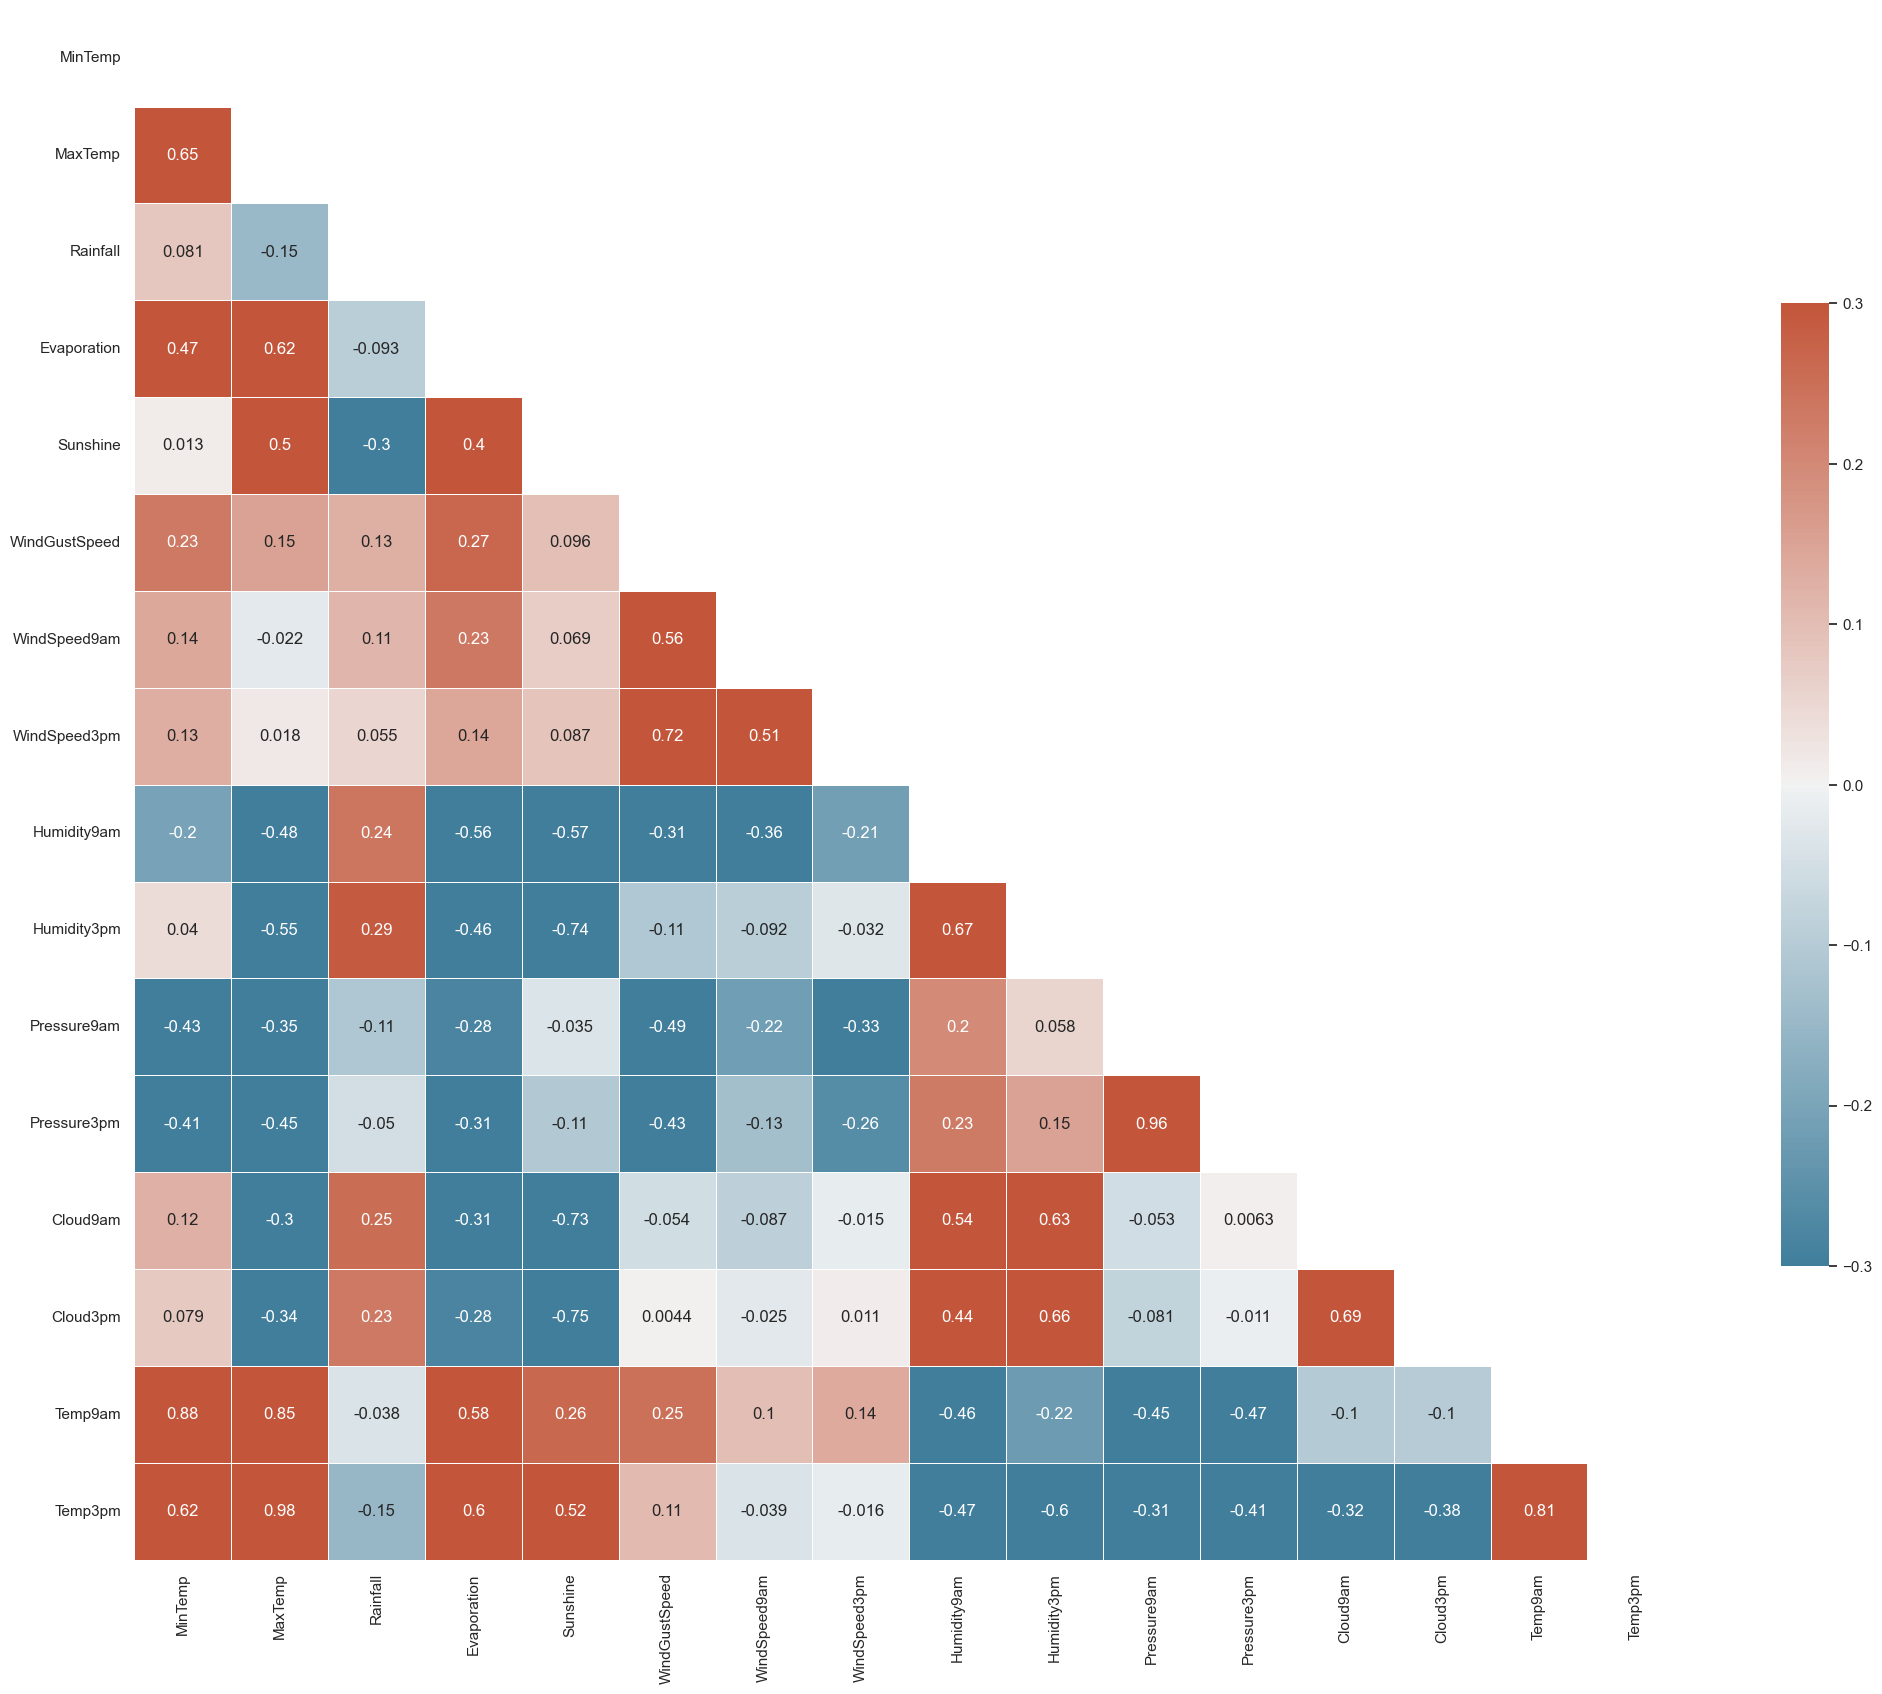

In [176]:
sns.set_theme(style="white")
# Creación de la matriz de correlación
corr = train_dummies[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']].corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(25, 25))

# Generar un colormap diverging personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el heatmap con la máscara y el aspecto correcto
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


## Matriz de correlación categórica

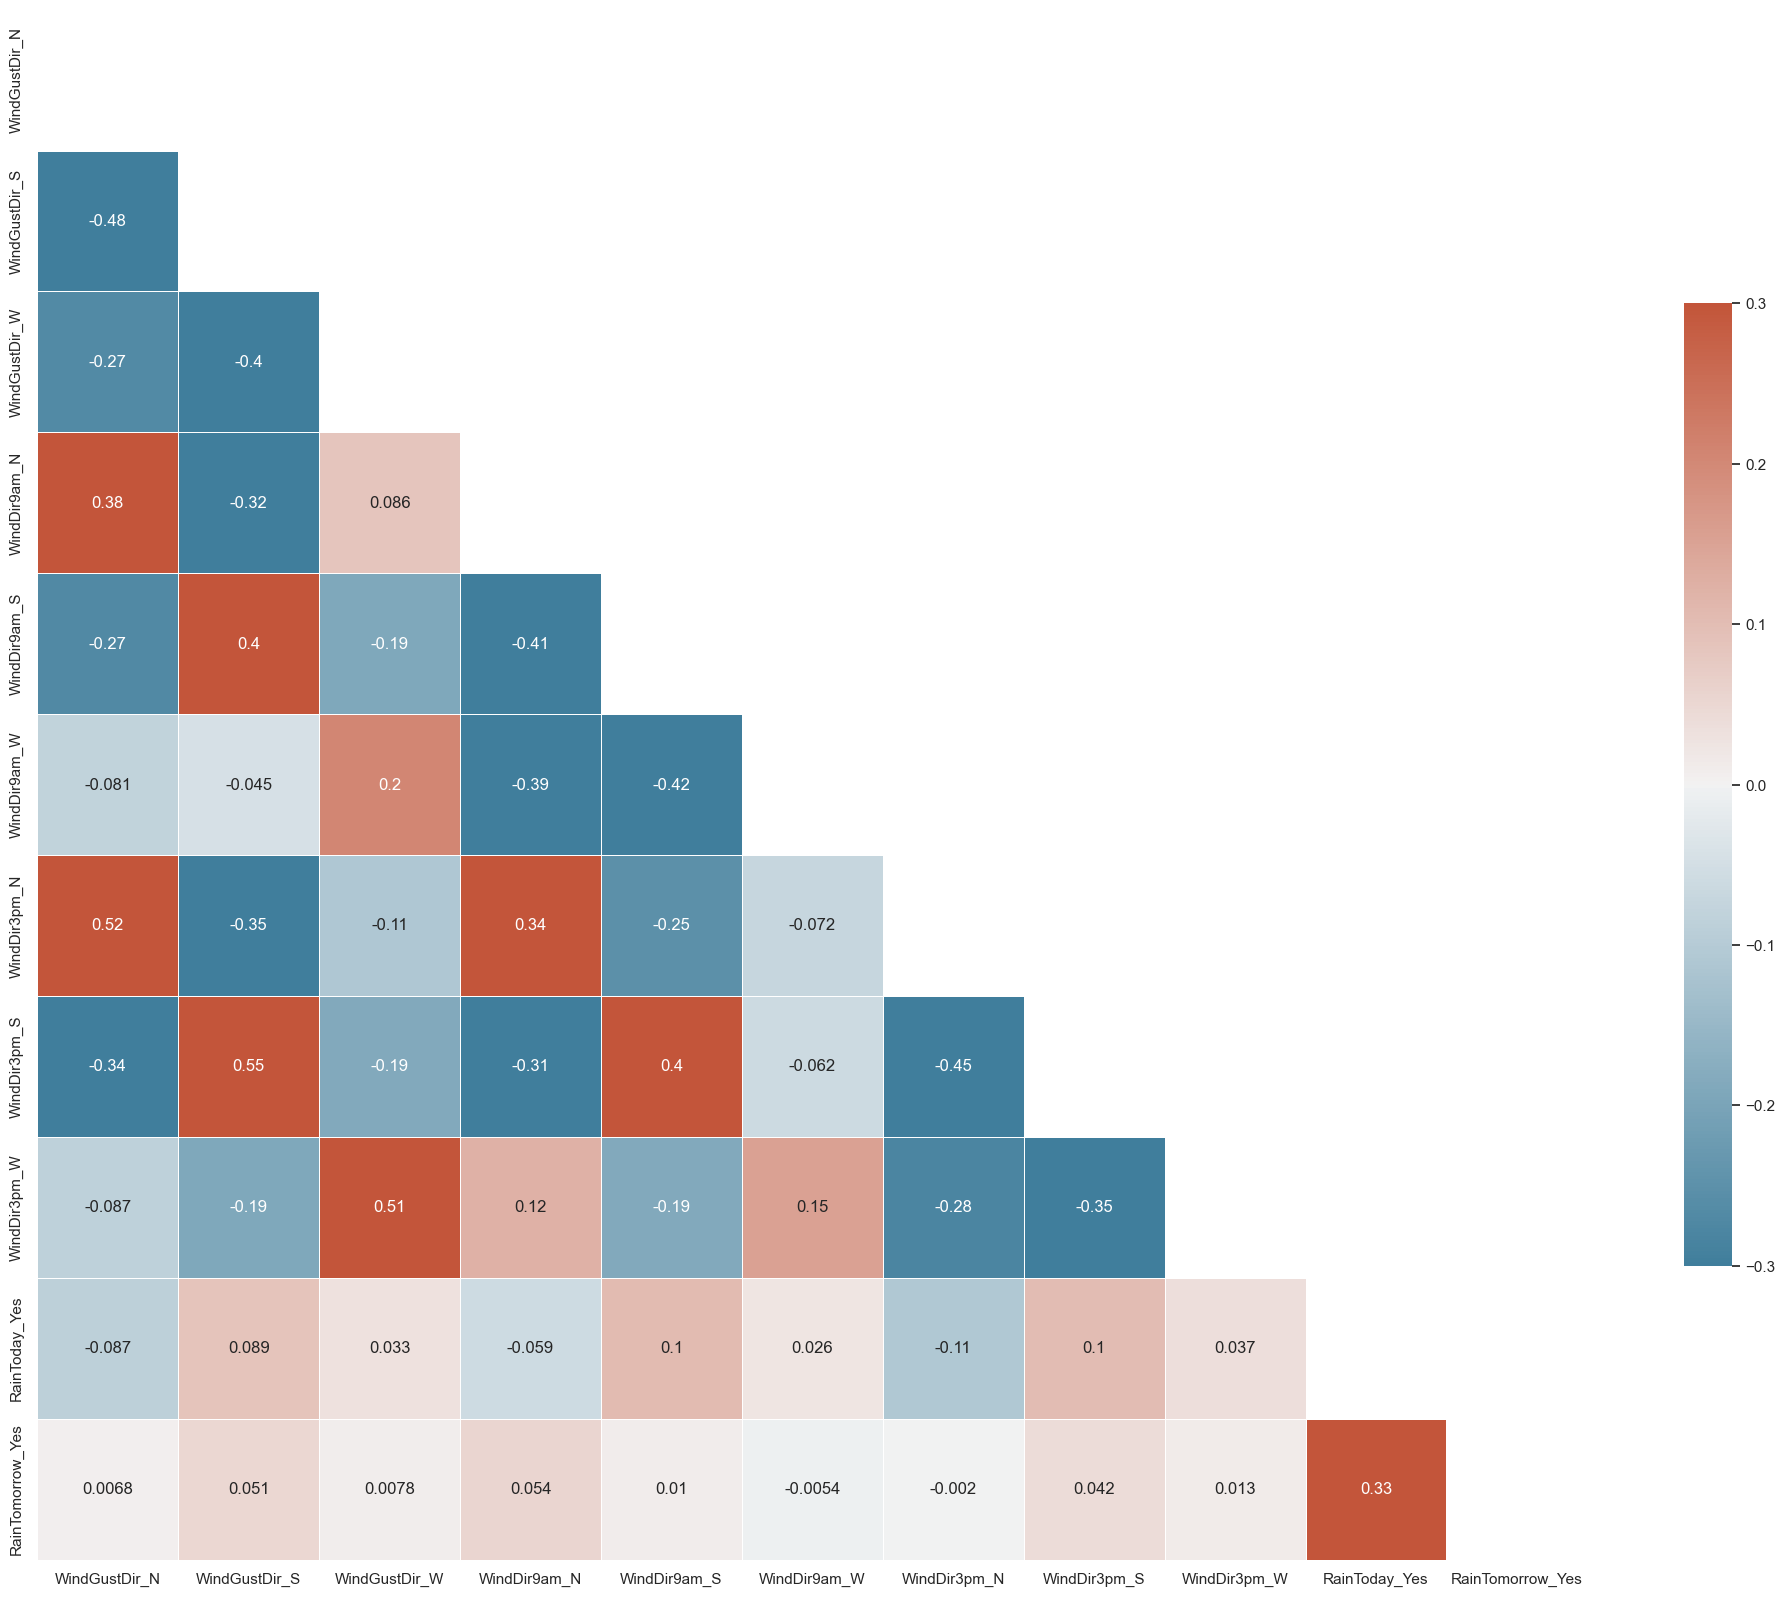

In [177]:
sns.set_theme(style="white")

# Calcular la matriz de correlación
corr = train_dummies[['WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainTomorrow_Yes']].corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(25, 25))

# Generar un colormap diverging personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el heatmap con la máscara y el aspecto correcto
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


La razón por la cual realizamos la matriz de correlación solo en el conjunto de entrenamiento (train) y no en el de prueba (test) es para evitar lo que se conoce como data leakage.

- **Data leakage** ocurre cuando utilizas información del conjunto de prueba (test) para tomar decisiones durante el entrenamiento del modelo.

# Estandarización

Estandarizamos las características porque pueden tener diferentes rangos de valores.
Estandarizarlas asegura que todas las características tengan la misma escala, lo que evita que las características
con mayores rangos dominen el modelo.

In [178]:
# Crear el estandarizador
scaler = StandardScaler()

## Estandarización de Train

In [179]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
# Aplicar la estandarización a las columnas seleccionadas
train_dummies[columns_to_standardize] = scaler.fit_transform(train_dummies[columns_to_standardize])

In [180]:
train_dummies

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
3040,0.200331,1.670124,-0.310925,0.368131,0.657228,1.575744,-0.243977,1.158552,-0.172204,-0.785764,...,0,1,1,0,0,0,1,0,0,0
3041,0.453051,0.422761,-0.310925,0.486047,0.858783,0.487047,-0.687153,0.671208,-0.573478,0.145949,...,1,0,0,1,0,0,1,0,0,0
3042,0.254485,-0.162421,-0.310925,-0.036153,0.669443,-0.674230,-0.797947,-0.325631,-0.673797,0.007576,...,0,0,0,0,0,1,0,0,0,0
3043,0.994594,1.208138,-0.310925,-0.065632,0.761059,-0.021012,-0.465565,-0.325631,-0.423000,-0.361420,...,0,0,1,0,0,1,0,0,0,0
3044,0.597462,2.378503,-0.310925,0.949289,1.243570,0.777366,-0.687153,-0.104111,-0.172204,-1.468406,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144905,2.023525,2.547898,-0.310925,2.692763,1.463448,-0.021012,0.199199,-1.322471,-1.325867,-1.514530,...,0,0,1,0,0,1,0,0,0,0
144906,2.095731,1.069542,-0.310925,0.326018,0.254118,0.269307,-0.022389,0.228169,-0.222364,0.561069,...,1,0,0,0,0,1,0,0,0,1
144907,2.059628,1.731722,0.385440,0.410244,0.809921,0.341887,1.861108,-0.104111,-0.322682,-0.361420,...,0,0,0,0,0,0,0,0,1,0
144909,2.131833,2.332304,0.455077,4.082489,1.304647,-0.021012,1.196344,-0.990191,-0.974752,-1.191659,...,0,0,0,0,0,1,0,0,0,0


## Estandarización de Test

In [181]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

# Aplicar la estandarización a las columnas seleccionadas
test_dummies[columns_to_standardize] = scaler.transform(test_dummies[columns_to_standardize])

In [182]:
test_dummies

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
5500,0.416948,0.438161,-0.310925,-0.364634,-0.582641,-0.601650,-1.019535,-1.211711,-0.222364,0.238198,...,0,0,0,0,0,0,0,0,0,0
5501,0.633565,0.915546,-0.310925,0.128087,-1.700356,-0.674230,-0.243977,-0.768671,0.279229,1.483558,...,0,0,1,0,0,1,0,0,0,0
5502,0.615514,0.099371,-0.310925,-0.234084,0.602258,-0.166172,0.642374,-0.104111,0.128751,-0.269171,...,1,0,0,1,0,0,0,0,0,0
5503,0.489154,0.006973,-0.310925,0.056495,0.614474,-0.311331,0.199199,-0.104111,-0.322682,0.007576,...,1,0,0,1,0,0,1,0,0,0
5504,0.164228,0.576756,-0.310925,-0.398324,0.938184,-0.674230,-0.465565,-0.990191,-0.523319,-0.545917,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,-1.568709,-0.239419,-0.310925,-0.330943,0.864891,-0.601650,0.199199,-0.547151,-0.573478,-1.099410,...,0,0,0,0,0,0,0,0,0,0
145455,-1.695069,0.006973,-0.310925,-0.314098,0.828244,-0.601650,-0.022389,-0.768671,-0.974752,-1.237784,...,0,0,0,1,0,0,0,0,0,0
145456,-1.550657,0.299565,-0.310925,-0.145646,0.089209,-1.254869,-0.022389,-0.990191,-0.723956,-1.376157,...,0,0,0,1,0,1,0,0,0,0
145457,-1.225732,0.545957,-0.310925,0.043862,0.174717,-0.166172,-0.465565,-0.990191,-0.874433,-1.237784,...,0,0,0,1,0,0,0,1,0,0


**En el conjunto de entrenamiento:**
Se aplica fit_transform del StandardScaler para ajustar el escalador a los datos de entrenamiento y transformar esos datos.

**En el conjunto de prueba:**
Se aplica transform del StandardScaler ya ajustado para transformar los datos de prueba usando la misma media y desviación estándar que en el conjunto de entrenamiento.

Esto asegura una transformación consistente y evita la fuga de información.



In [183]:
import joblib

# Serializar scaler
joblib.dump(scaler, 'docker/model/scaler.joblib')


['docker/model/scaler.joblib']

# División del conjunto de datos de entrenamiento


In [184]:

y_train = train_dummies['RainTomorrow_Yes']
x_train = train_dummies.drop(['RainTomorrow_Yes'], axis=1)

y_test = test_dummies['RainTomorrow_Yes']
x_test = test_dummies.drop(['RainTomorrow_Yes'], axis=1)


In [185]:
x_train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_N,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes
3040,0.200331,1.670124,-0.310925,0.368131,0.657228,1.575744,-0.243977,1.158552,-0.172204,-0.785764,...,0,0,1,1,0,0,0,1,0,0
3041,0.453051,0.422761,-0.310925,0.486047,0.858783,0.487047,-0.687153,0.671208,-0.573478,0.145949,...,0,1,0,0,1,0,0,1,0,0
3042,0.254485,-0.162421,-0.310925,-0.036153,0.669443,-0.674230,-0.797947,-0.325631,-0.673797,0.007576,...,1,0,0,0,0,0,1,0,0,0
3043,0.994594,1.208138,-0.310925,-0.065632,0.761059,-0.021012,-0.465565,-0.325631,-0.423000,-0.361420,...,1,0,0,1,0,0,1,0,0,0
3044,0.597462,2.378503,-0.310925,0.949289,1.243570,0.777366,-0.687153,-0.104111,-0.172204,-1.468406,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144905,2.023525,2.547898,-0.310925,2.692763,1.463448,-0.021012,0.199199,-1.322471,-1.325867,-1.514530,...,0,0,0,1,0,0,1,0,0,0
144906,2.095731,1.069542,-0.310925,0.326018,0.254118,0.269307,-0.022389,0.228169,-0.222364,0.561069,...,0,1,0,0,0,0,1,0,0,0
144907,2.059628,1.731722,0.385440,0.410244,0.809921,0.341887,1.861108,-0.104111,-0.322682,-0.361420,...,0,0,0,0,0,0,0,0,0,1
144909,2.131833,2.332304,0.455077,4.082489,1.304647,-0.021012,1.196344,-0.990191,-0.974752,-1.191659,...,0,0,0,0,0,0,1,0,0,0


In [186]:
y_train

3040      0
3041      0
3042      0
3043      0
3044      0
         ..
144905    0
144906    1
144907    0
144909    0
144910    1
Name: RainTomorrow_Yes, Length: 21633, dtype: int64

# Balanceamos los datos:
Realizamos un balanceo de datos en el conjunto de entrenamiento utilizando la técnica SMOTETomek, mientras que mantenemos el conjunto de prueba sin cambios. 

In [187]:
from imblearn.combine import SMOTETomek

# Aplicar SMOTETomek solo al conjunto de entrenamiento
smote_tomek = SMOTETomek(random_state=42)

# Asegurarse de que y_train no sea un DataFrame
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]

# Reemplazar directamente X_train y y_train con los datos balanceados
x_train, y_train = smote_tomek.fit_resample(x_train, y_train)

# El conjunto de prueba se mantiene sin cambios
x_test, y_test = x_test, y_test  # No hacemos nada con X_test ni y_test

# Verificar las formas de los datos balanceados
print("Tamaño de X_train después de SMOTETomek:", x_train.shape)
print("Tamaño de y_train después de SMOTETomek:", y_train.shape)
print("Tamaño de X_test (sin cambios):", x_test.shape)
print("Tamaño de y_test (sin cambios):", y_test.shape)


Tamaño de X_train después de SMOTETomek: (33802, 26)
Tamaño de y_train después de SMOTETomek: (33802,)
Tamaño de X_test (sin cambios): (5405, 26)
Tamaño de y_test (sin cambios): (5405,)


In [188]:
print("X_train_balanced shape:", x_train.shape)
print("y_train_encoded shape:", y_train.shape)


X_train_balanced shape: (33802, 26)
y_train_encoded shape: (33802,)


In [189]:

print("\nDistribución después del balanceo:")
print(pd.Series(y_train).value_counts(normalize=True))


Distribución después del balanceo:
RainTomorrow_Yes
0    0.5
1    0.5
Name: proportion, dtype: float64


# Regresión Logística (Clasificación).


In [190]:
# Inicializar y entrenar un modelo de regresión logística
model = LogisticRegression()
start = time.time()
model.fit(x_train, np.ravel(y_train))
end = time.time()

no_opt_time = end - start

# Realizar predicciones en el conjunto de prueba
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
model

LogisticRegression()

In [191]:
# Calcular métricas
accuracy_logreg = accuracy_score(y_train, y_pred_train) # compara el valor real y el predicho

confusion_matrix_logreg = confusion_matrix(y_train, y_pred_train)

classification_report_logreg = classification_report(y_train, y_pred_train)

# Imprimir métricas
print("Métricas para logreg train:")
print(f'Precisión: {accuracy_logreg}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg train:
Precisión: 0.797615525708538
Matriz de confusión:
[[13665  3236]
 [ 3605 13296]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80     16901
           1       0.80      0.79      0.80     16901

    accuracy                           0.80     33802
   macro avg       0.80      0.80      0.80     33802
weighted avg       0.80      0.80      0.80     33802



In [192]:
# Calcular métricas
accuracy_logreg = accuracy_score(y_test, y_pred_test)

confusion_matrix_logreg = confusion_matrix(y_test, y_pred_test)

classification_report_logreg = classification_report(y_test, y_pred_test)

# Imprimir métricas
print("Métricas para logreg test:")
print(f'Precisión: {accuracy_logreg}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg test:
Precisión: 0.7966697502312673
Matriz de confusión:
[[3406  850]
 [ 249  900]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      4256
           1       0.51      0.78      0.62      1149

    accuracy                           0.80      5405
   macro avg       0.72      0.79      0.74      5405
weighted avg       0.84      0.80      0.81      5405



**Conjunto de entrenamiento:**
El F1-score para la clase positiva (1) es 0.78, lo que indica un buen balance entre precisión y recall. Esto sugiere que el modelo está capturando correctamente los positivos en el conjunto de entrenamiento, logrando un buen desempeño.
**Conjunto de prueba:**
El F1-score para la clase positiva (1) baja a 0.57, lo que implica una caída significativa en el rendimiento al predecir la clase positiva en datos no vistos. Esta diferencia sugiere que el modelo puede estar sobreajustado al conjunto de entrenamiento o que hay una mayor complejidad en los datos del conjunto de prueba.

# Matriz de confusion

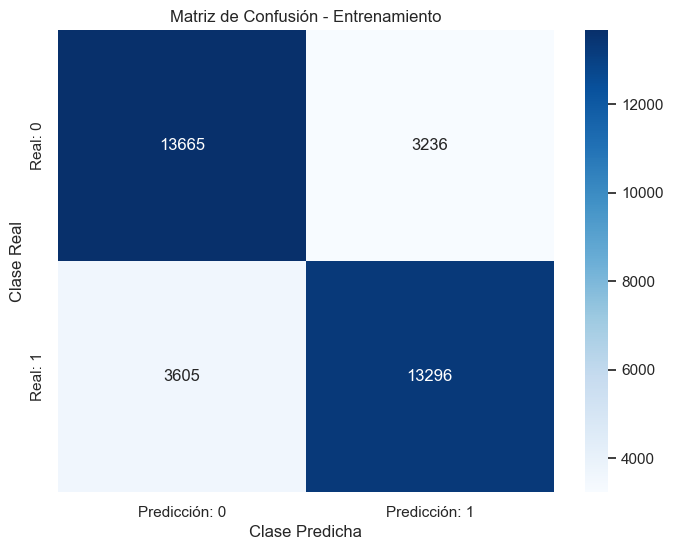

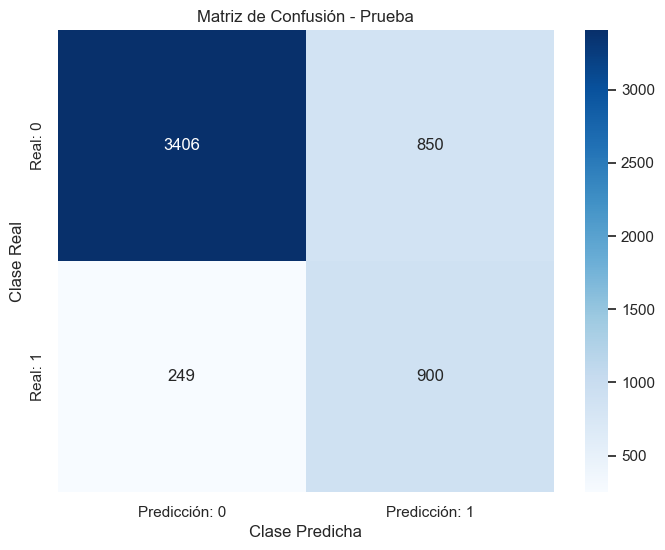

In [193]:

# Calcular matrices de confusión
confusion_matrix_logreg_train = confusion_matrix(y_train, y_pred_train)
confusion_matrix_logreg_test = confusion_matrix(y_test, y_pred_test)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, title='Matriz de Confusión', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=['Predicción: 0', 'Predicción: 1'],
                yticklabels=['Real: 0', 'Real: 1'])
    plt.title(title)
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.show()

# Graficar matriz de confusión para el conjunto de entrenamiento
plot_confusion_matrix(confusion_matrix_logreg_train, title='Matriz de Confusión - Entrenamiento')

# Graficar matriz de confusión para el conjunto de prueba
plot_confusion_matrix(confusion_matrix_logreg_test, title='Matriz de Confusión - Prueba')


  ***Conclusión de la Matriz:***

**Clase Negativa (Clase 0):**  
- En el conjunto de prueba, de un total de **4,650 casos negativos**:
  - El modelo clasifica correctamente **3,587 casos** (77.1%).
  - Se equivoca en **1,063 casos**, clasificándolos erróneamente como positivos.

**Clase Positiva (Clase 1):**  
- En el conjunto de prueba, de un total de **1,342 casos positivos**:
  - El modelo identifica correctamente **960 casos** (71.6%).
  - Falla en **382 casos**, clasificándolos como negativos.

El modelo presenta un buen equilibrio en la predicción de ambas clases, aunque la precisión en la detección de la **Clase Negativa (Clase 0)** es ligeramente inferior en comparación con la **Clase Positiva (Clase 1)** en este conjunto de datos.

# Curva Roc

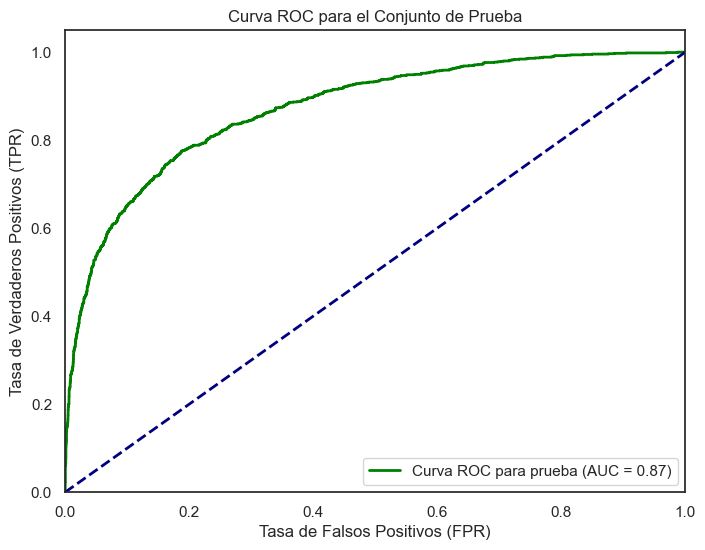

El área bajo la curva para prueba es de: 0.871388245417722


In [194]:
# Reemplaza 'No' con 0 y 'Yes' con 1
y_test_binary = y_test.replace({'No': 0, 'Yes': 1})

# Obtengo las probabilidades de predicción del modelo para los datos de prueba
y_probs_test = model.predict_proba(x_test)[:, 1]

# Calculo la ROC y el AUC para los datos de prueba
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_probs_test, pos_label=1)
roc_auc_test = auc(fpr_test, tpr_test)

# Grafico la curva ROC para los datos de prueba
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='Curva ROC para prueba (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para el Conjunto de Prueba')
plt.legend(loc="lower right")
plt.show()

print(f"El área bajo la curva para prueba es de: {roc_auc_test}")



In [195]:
# Calcula la distancia euclidiana entre cada punto de la curva ROC y (0,1) para los datos de prueba
distances_test = np.sqrt((1 - tpr_test)**2 + fpr_test**2)

# Encuentra el índice del punto que minimiza la distancia para los datos de prueba
min_index_test = np.argmin(distances_test)

# Obtiene el umbral óptimo para los datos de prueba
optimal_threshold_test = thresholds_test[min_index_test]

print("Umbral óptimo para prueba:", optimal_threshold_test)

Umbral óptimo para prueba: 0.5170471935717726


### Curva ROC, Umbral y Área Bajo la Curva

AUC: 0.8212

Umbral óptimo: 0.4680

- La curva ROC muestra que el modelo tiene un desempeño excelente tanto en el conjunto de entrenamiento como en el de prueba, con AUC cercanas a 1. Esto indica que el modelo es muy eficaz para diferenciar entre las clases.
- Los umbrales óptimos sugieren los puntos donde el modelo equilibra mejor la tasa de verdaderos positivos y la tasa de falsos positivos.

In [86]:
import pickle

# Guardar modelo con un nombre identificador
model_name = "ModelRL"  # Cambia este nombre según el modelo
model_path = f'docker/model/{model_name}.pkl'

with open(model_path, 'wb') as model_file:
    pickle.dump(model, model_file)

print(f'Modelo guardado en: {model_path}')

Modelo guardado en: docker/model/ModelRL.pkl


In [207]:
x_train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W',
       'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N',
       'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes'],
      dtype='object')

# Modelo Base

In [196]:
# Entrena el modelo base
logreg_base = LogisticRegression()
logreg_base.fit(x_train, y_train)

LogisticRegression()

In [197]:

# Realiza predicciones
y_pred_train_base = logreg_base.predict(x_train)
y_pred_test_base = logreg_base.predict(x_test)

# Calcula métricas para el conjunto de entrenamiento
print("Métricas de entrenamiento para el modelo base de clasificación:")
print("Precisión:", logreg_base.score(x_train, y_train))
print("Matriz de confusión:\n", confusion_matrix(y_train, y_pred_train_base))
print("Reporte de clasificación:\n", classification_report(y_train, y_pred_train_base))

# Calcula métricas para el conjunto de prueba
print("Métricas de prueba para el modelo base de clasificación:")
print("Precisión:", logreg_base.score(x_test, y_test))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_test_base))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_test_base))


Métricas de entrenamiento para el modelo base de clasificación:
Precisión: 0.797615525708538
Matriz de confusión:
 [[13665  3236]
 [ 3605 13296]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80     16901
           1       0.80      0.79      0.80     16901

    accuracy                           0.80     33802
   macro avg       0.80      0.80      0.80     33802
weighted avg       0.80      0.80      0.80     33802

Métricas de prueba para el modelo base de clasificación:


Precisión: 0.7966697502312673
Matriz de confusión:
 [[3406  850]
 [ 249  900]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.93      0.80      0.86      4256
           1       0.51      0.78      0.62      1149

    accuracy                           0.80      5405
   macro avg       0.72      0.79      0.74      5405
weighted avg       0.84      0.80      0.81      5405



El modelo muestra un desempeño razonable con una precisión global del **77.7% en entrenamiento** y **75.9% en prueba**, reflejando una ligera disminución esperada. Aunque el **F1-score es consistente en ambas clases en entrenamiento (0.78)**, en prueba se observa una discrepancia, con un **F1-score menor para la clase positiva (0.57 frente a 0.83 para la clase negativa)**, evidenciando mayores desafíos en la predicción de los casos positivos.

# Optimizar la selección de hiperparámetros.



### Validación cruzada k-folds

Evitamos usar Leave-One-Out debido a que nuestro conjunto de datos es grande, y sabemos que Leave-One-Out puede ser muy costoso en términos de tiempo para datasets de gran tamaño. Optamos por StratifiedKFold, ya que es ideal para problemas de clasificación con clases desbalanceadas, como es nuestro caso.

In [90]:

# Dividir el conjunto de datos en entrenamiento y validación
x_train_k, x_val_k, y_train_k, y_val_k = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


In [91]:
# Definir el modelo y las estrategias de validación cruzada
clf = RandomForestClassifier(random_state=42)
cv_strategies = [
    ("KFold", KFold(n_splits=5, shuffle=True, random_state=42)),
    ("StratifiedKFold", StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
]

results = {}
for name, cv in cv_strategies:
    scores = cross_val_score(clf, x_train, y_train, cv=cv)  # Cambiado a x_train y y_train completos
    results[name] = scores

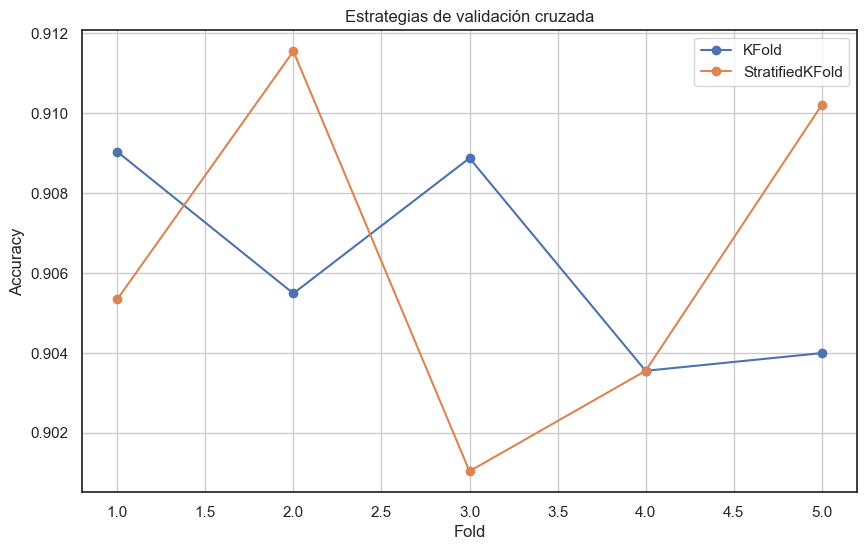

In [92]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
for name, scores in results.items():
    plt.plot(range(1, len(scores) + 1), scores, marker='o', label=name)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Estrategias de validación cruzada")
plt.legend()
plt.grid(True)
plt.show()


El gráfico compara las estrategias de validación cruzada `KFold` y `StratifiedKFold`. Ambos métodos muestran precisión similar en promedio; sin embargo, `StratifiedKFold` presenta mayor variabilidad, con una caída abrupta en el último fold. Esto se debe al desbalance de clases en el dataset, lo cual dificulta mantener una distribución equilibrada en cada partición. Aunque `KFold` parece más estable, `StratifiedKFold` sigue siendo preferible para datasets desbalanceados, ya que busca preservar la proporción de clases en cada fold, ofreciendo una evaluación más representativa del modelo.

In [93]:
# Imprimir los resultados
for name, scores in results.items():
    print(f"Accuracy para cada {name}: ", scores)
    print(f"Media para la estrategia {name}: {scores.mean()}")
    print(f"Desvío estándar para la estrategia {name}: {scores.std()}")

Accuracy para cada KFold:  [0.90903712 0.90548735 0.90887574 0.9035503  0.90399408]
Media para la estrategia KFold: 0.9061889193941235
Desvío estándar para la estrategia KFold: 0.002349600484807378
Accuracy para cada StratifiedKFold:  [0.90533945 0.91155155 0.9010355  0.9035503  0.9102071 ]
Media para la estrategia StratifiedKFold: 0.9063367783730042
Desvío estándar para la estrategia StratifiedKFold: 0.00397582362919679


A pesar de que StratifiedKFold tiene una precisión promedio un poco superior, también muestra más variabilidad en los resultados debido al desbalance de clases en el dataset. Esto hace que KFold sea ligeramente más estable, pero StratifiedKFold sigue siendo la mejor opción para representar de forma más equitativa la distribución de clases en datasets desbalanceados.

## Grid Search

In [94]:

# Definir los parámetros para Grid Search
param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

In [95]:

# Inicializar GridSearchCV con el modelo y la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Medir el tiempo de ejecución de la búsqueda de hiperparámetros
start = time.time()
grid_search.fit(x_train, np.ravel(y_train))
end = time.time()
grid_search_time = end - start


Fitting 5 folds for each of 42 candidates, totalling 210 fits


In [96]:
# Predicciones del modelo con Grid Search
y_pred_grid_search = grid_search.predict(x_test)


In [97]:
# Cálculo de las métricas
grid_search_accuracy = accuracy_score(y_test, y_pred_grid_search)
grid_search_precision = precision_score(y_test, y_pred_grid_search, average='weighted')
grid_search_recall = recall_score(y_test, y_pred_grid_search, average='weighted')
classification_report_grid_search = classification_report(y_test, y_pred_grid_search, zero_division=1)

# Imprimir los resultados
print(f"Grid Search Time: {grid_search_time:.4f} seconds")
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print('\n--- Métricas del modelo con Grid Search ---')
print(f'Accuracy: {grid_search_accuracy:.4f}')
print(f'Precision: {grid_search_precision:.4f}')
print(f'Recall: {grid_search_recall:.4f}')
print("\nReporte de clasificación:")
print(classification_report_grid_search)

Grid Search Time: 27.6702 seconds
Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.7810196620191159

--- Métricas del modelo con Grid Search ---
Accuracy: 0.7928
Precision: 0.8409
Recall: 0.7928

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      4256
           1       0.51      0.78      0.62      1149

    accuracy                           0.79      5405
   macro avg       0.72      0.79      0.74      5405
weighted avg       0.84      0.79      0.81      5405




- **Clase 1:** Moderada precisión (50%) pero buen recall (78%), reflejando cierto compromiso en capturar positivos con errores en predicciones.

El **F1-score** para la clase 1 **(0.61)** sugiere que, aunque el modelo es razonablemente eficaz en identificar positivos, hay margen de mejora, especialmente para equilibrar precisión y recall en esta clase.

## Random Search

In [98]:

# Definir los parámetros para Random Search
random_param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': np.logspace(-4, 4, 20)},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': np.logspace(-4, 4, 20)}
]

In [99]:

# Ejecutar la búsqueda de hiperparámetros con Random Search
random_search = RandomizedSearchCV(estimator=model, param_distributions=random_param_grid, n_iter=10, cv=5, n_jobs=-1)
start = time.time()
random_search.fit(x_train, np.ravel(y_train))
end = time.time()
random_search_time = end - start

In [100]:
# Realizar predicciones con el modelo de Random Search
y_pred_random_search = random_search.predict(x_test)


In [101]:
# Calcular las métricas para el modelo con Random Search
random_search_accuracy = accuracy_score(y_test, y_pred_random_search)
random_search_precision = precision_score(y_test, y_pred_random_search, average='weighted')
random_search_recall = recall_score(y_test, y_pred_random_search, average='weighted')
classification_report_random_search = classification_report(y_test, y_pred_random_search, zero_division=1)

# Imprimir los resultados
print(f'Accuracy: {random_search_accuracy:.4f}')
print(f'Precision: {random_search_precision:.4f}')
print(f'Recall: {random_search_recall:.4f}')
print('Reporte de clasificación:')
print(classification_report_random_search)

print(f"Tiempo de Random Search: {random_search_time:.4f} segundos")

Accuracy: 0.7932
Precision: 0.8411
Recall: 0.7932
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      4256
           1       0.51      0.78      0.62      1149

    accuracy                           0.79      5405
   macro avg       0.72      0.79      0.74      5405
weighted avg       0.84      0.79      0.81      5405

Tiempo de Random Search: 4.8517 segundos


El modelo ajustado con **Random Search** presenta las siguientes métricas:

- **Accuracy (74%)**: Buen desempeño general en las predicciones correctas, considerando el desbalance de clases.

- **Clase 1**:  con un **F1-score (0.61)** aceptable, aunque hay margen de mejora.

El tiempo reducido de 6.05 segundos para Random Search demuestra una optimización eficiente frente al Grid Search, con resultados comparables. Sin embargo, el modelo sigue favoreciendo a la clase mayoritaria.

## Optuna

In [198]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score


# Función de entrenamiento y evaluación del modelo
def train_evaluate_model(params, X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Usar 'weighted' para clases desbalanceadas
    return f1


In [199]:

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        # Ajustar max_features a valores válidos para RandomForestClassifier
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5])
    }
    # Evaluar el modelo con los parámetros actuales
    f1 = train_evaluate_model(params, x_train, y_train, x_test, y_test)
    return f1


In [200]:

# Configuración de la búsqueda con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=-1)  # Aumentar n_trials para una búsqueda más exhaustiva

# Mejor modelo encontrado
best_optuna_params = study.best_params
best_optuna_model = RandomForestClassifier(**best_optuna_params, random_state=42)
best_optuna_model.fit(x_train, y_train)

# Evaluación del modelo final
y_pred = best_optuna_model.predict(x_test)
print("Best Hyperparameters:", best_optuna_params)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Validación cruzada
cv_scores = cross_val_score(best_optuna_model, x_train, y_train, cv=5, scoring='f1_weighted')
print(f"\nCross-Validation Mean F1 Score: {cv_scores.mean():.4f}, Std Dev: {cv_scores.std():.4f}")

# Métricas adicionales en el conjunto de prueba original
print("\nEvaluación en los datos de prueba originales:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score (Weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")


[I 2024-11-29 13:05:02,361] A new study created in memory with name: no-name-a0b5a518-9345-4b52-a626-21df592ce47e
[I 2024-11-29 13:05:15,196] Trial 4 finished with value: 0.8145468011208921 and parameters: {'n_estimators': 91, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 4 with value: 0.8145468011208921.
[I 2024-11-29 13:05:19,206] Trial 7 finished with value: 0.7904106160916975 and parameters: {'n_estimators': 179, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 4 with value: 0.8145468011208921.
[I 2024-11-29 13:05:22,180] Trial 0 finished with value: 0.836182449915625 and parameters: {'n_estimators': 104, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.836182449915625.
[I 2024-11-29 13:05:25,121] Trial 1 finished with value: 0.8437419064174668 and parameters: {'n_estimators': 101, 'max_depth': 20, 'min_sa

Best Hyperparameters: {'n_estimators': 91, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4256
           1       0.62      0.68      0.64      1149

    accuracy                           0.84      5405
   macro avg       0.76      0.78      0.77      5405
weighted avg       0.85      0.84      0.84      5405


Confusion Matrix:
[[3773  483]
 [ 373  776]]

Cross-Validation Mean F1 Score: 0.8716, Std Dev: 0.0322

Evaluación en los datos de prueba originales:
Accuracy: 0.8416
F1 Score (Weighted): 0.8442


El modelo optimizado con **Optuna** demuestra un desempeño sólido:

- **Clase 1 (minoritaria):** Mejora notable con un recall de 68% y una precision de 62% un **F1-score (0.65)**.


In [201]:
import joblib

model_name = "modelOp"  # Cambiar según el modelo
model_path = f'docker/model/{model_name}.joblib'

# Guardar el modelo con el nombre indicado
joblib.dump(model, model_path)

print(f'Modelo guardado como: {model_path}')


Modelo guardado como: docker/model/modelOp.joblib


### Justificación del uso de Grid Search, Optuna y Random Search:


**Grid Search** , **Random Search** y **Optuna:** son técnicas de búsqueda para encontrar los mejores hiperparámetros para un modelo. Ambas se utilizan para optimizar el rendimiento del modelo ajustando parámetros clave que afectan la calidad de las predicciones.

**Grid Search:** Busca exhaustivamente en una cuadrícula definida de hiperparámetros, probando todas las combinaciones posibles. Es adecuado cuando el espacio de búsqueda es pequeño y podemos tolerar el costo computacional.

**Random Search:** Selecciona de manera aleatoria combinaciones de hiperparámetros, lo cual puede ser más eficiente en términos de tiempo si el espacio de búsqueda es grande. Generalmente, permite explorar el espacio de forma más amplia en menor tiempo.

**Optuna:** Es una librería de optimización de hiperparámetros que usa algoritmos avanzados (como optimización bayesiana) para seleccionar los hiperparámetros de forma inteligente. Se adapta bien a espacios de búsqueda grandes y complejos, ya que puede encontrar buenas configuraciones en menos iteraciones.



**Justificación de los hiperparámetros optimizados:**

1. **Penalty**: Controla la regularización del modelo. **L1** (Lasso) elimina características irrelevantes, mientras que **L2** (Ridge) estabiliza el modelo sin eliminarlas. Se elige según la necesidad de regularización.

2. **Solver**: Determina el algoritmo de optimización. **liblinear** es bueno para datos pequeños con **L1**, mientras que **saga** y otros funcionan mejor con **L2** y grandes volúmenes de datos.

3. **C**: Regula la fuerza de la regularización. Un valor bajo previene el sobreajuste, pero un **C** muy bajo puede causar subajuste, mientras que uno alto puede llevar a sobreajuste.



# SHAP

Primero, aseguramos que las características (features) estén definidas correctamente como una lista de columnas para ser utilizadas en los gráficos de SHAP.

In [104]:
# Asegúrate de tener definidos los nombres de las características como una lista
feature_names = x_test.columns.tolist()


Creamos un LinearExplainer para un modelo de regresión logística utilizando los datos de entrenamiento (x_train). Luego calculamos los valores SHAP para el conjunto de test (x_test).

In [105]:
import shap
# Crear un objeto explainer SHAP para el modelo de regresión logística
explainer = shap.LinearExplainer(model, x_train)
shap_values = explainer.shap_values(x_test)

El valor esperado representa la probabilidad media de predicción del modelo, antes de observar cualquier característica.

In [106]:
expected_probability = 1 / (1 + np.exp(-explainer.expected_value))
print("Probabilidad esperada:", expected_probability)


Probabilidad esperada: 0.5030479567665295


## Interpretabilidad local

Para una instancia específica, podemos usar el force_plot, que descompone la predicción del modelo para ver cómo cada característica contribuye al resultado. Aquí se muestra para una instancia en el índice 0.

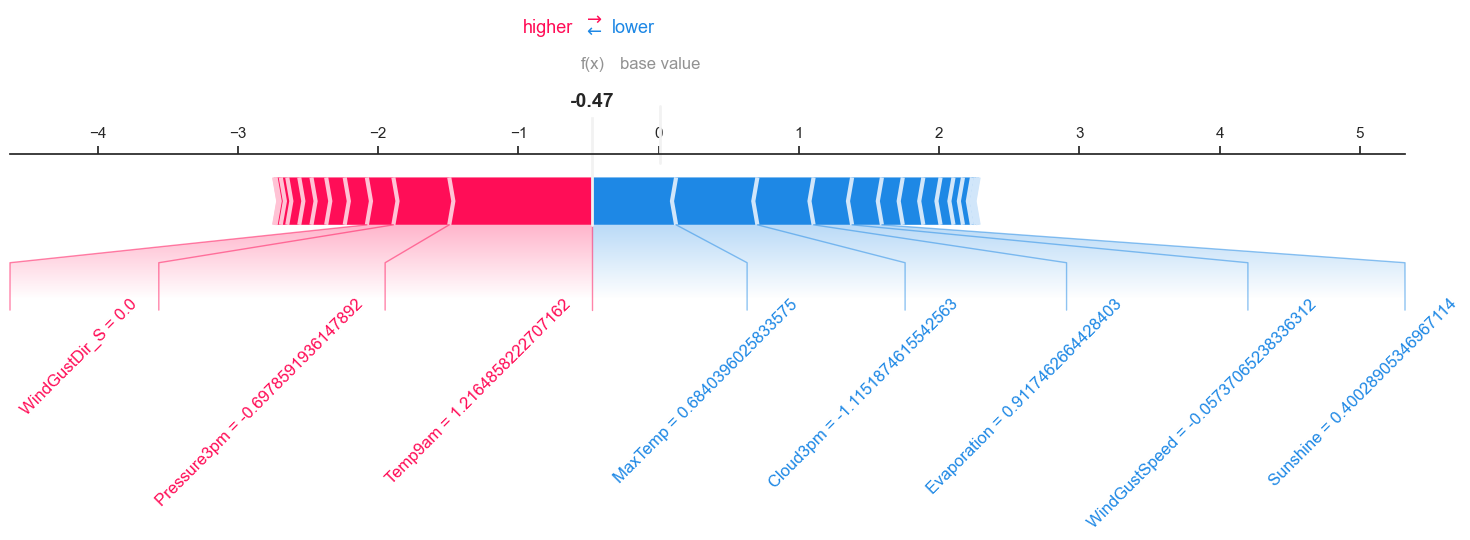

In [107]:
index=0
shap.force_plot(explainer.expected_value, shap_values[index], x_test.iloc[index],
                matplotlib=True, figsize=(18, 4),
                text_rotation=45)

Este gráfico explica la influencia de cada característica en la predicción de una instancia particular.

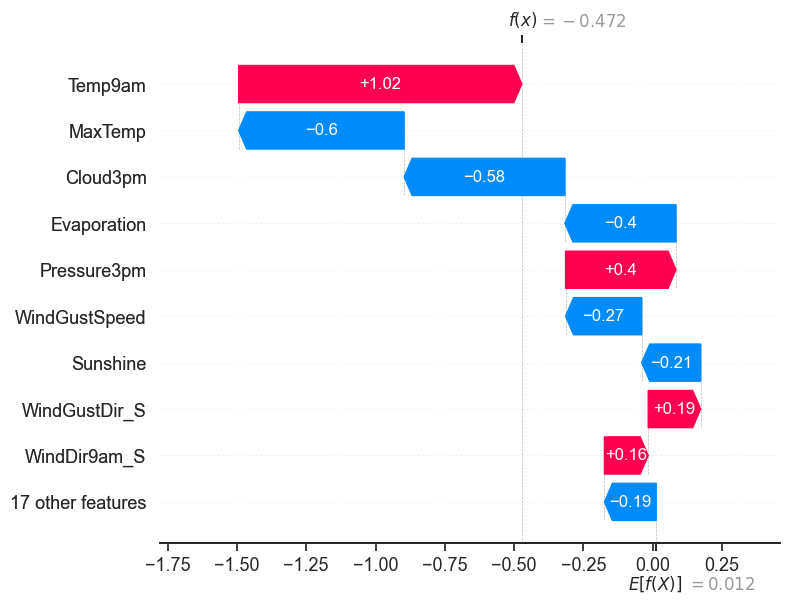

In [108]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)
shap.plots.waterfall(explanation)


El gráfico de cascada es útil para visualizar cómo las características contribuyen a la predicción de una instancia específica, mostrando una secuencia de barras que indican las contribuciones positivas o negativas de cada característica.

## Interpretabilidad global

Para analizar el impacto de todas las características en el modelo, el gráfico de barras (bar) y el gráfico de resumen (summary_plot) muestran la importancia global de cada característica a través de sus valores SHAP promedio.

Gráfico de barras: Muestra la importancia de cada característica en todas las predicciones.

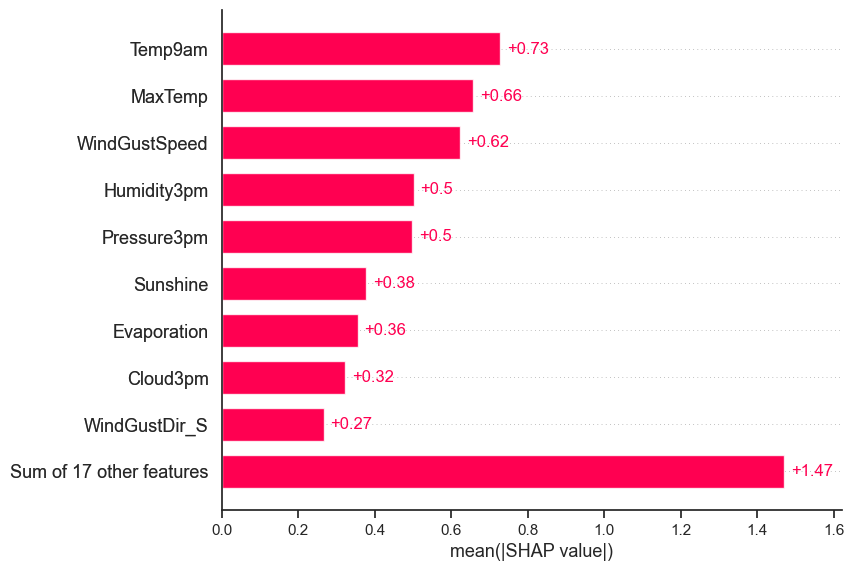

In [109]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=x_test)
shap.plots.bar(explanation)


**Gráfico resumen:** Muestra la distribución de los valores SHAP para cada característica. Las características más importantes se ubicarán en la parte superior del gráfico.

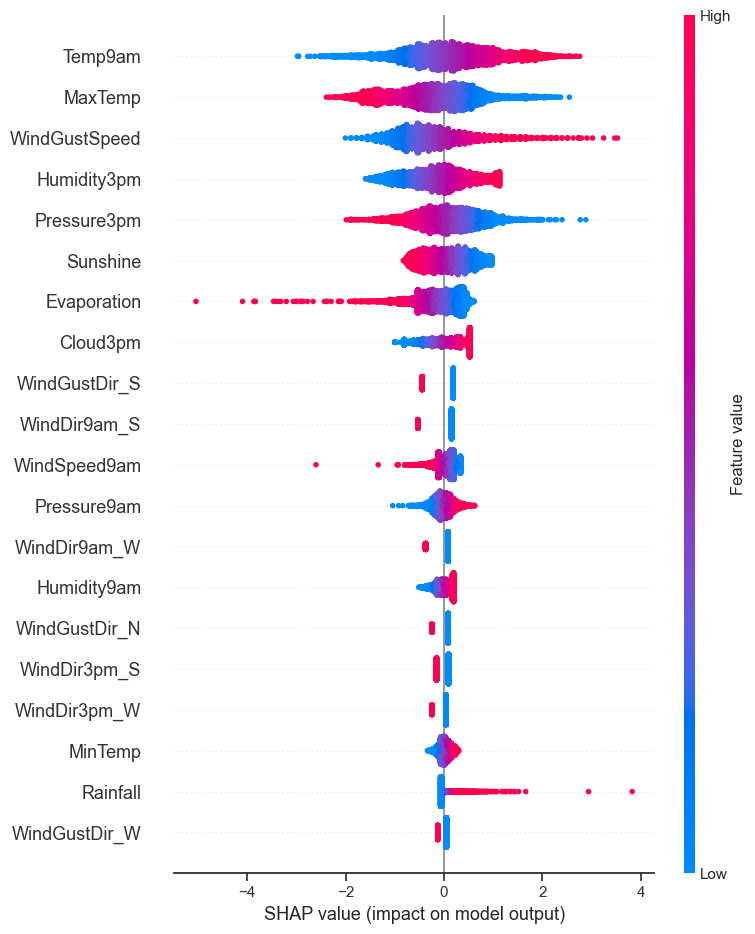

In [110]:
shap.summary_plot(shap_values, x_test, feature_names=x_test.columns)

En este gráfico, podemos observar que las características como HUMIDITY3PM,  PRESSURE3PM, WINGUSTSPEED, y PRESSURE9AM tienen una alta variabilidad en sus valores SHAP, lo que indica que tienen un impacto considerable en las predicciones del modelo.

### **Conclusiones:** 
Características más importantes: Se observa que las características HUMIDITY3PM, PRESSURE3PM, y WINGUSTSPEED son las más influyentes en las predicciones del modelo.
Impacto de las características: Las características con mayor variabilidad en los valores SHAP tienden a tener un mayor impacto en la predicción, mientras que las características con menos variabilidad son menos influyentes.
Interpretabilidad Local y Global: SHAP permite obtener una visión detallada tanto de las predicciones individuales (local) como del impacto global de cada característica en el modelo.

# Implementación de AutoML con scikit-learn

In [106]:
from tpot import TPOTClassifier
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report


In [108]:

# Configuración del clasificador TPOT
#tpot = TPOTClassifier(generations=5, population_size=20, cv=5, verbosity=2, random_state=42, n_jobs=-1)


tpot = TPOTClassifier(
    generations=5,
    population_size=10,
    cv=5,
    verbosity=2,
    random_state=42,
    n_jobs=-1,
    config_dict='TPOT light',
    max_time_mins=30
)

# Medir el tiempo de ejecución de TPOT
start = time.time()
tpot.fit(x_train, np.ravel(y_train))
end = time.time()
tpot_time = end - start

# Hacer predicciones con el modelo optimizado de TPOT
y_pred_tpot = tpot.predict(x_test)

# Calcular las métricas
tpot_accuracy = accuracy_score(y_test, y_pred_tpot)
tpot_precision = precision_score(y_test, y_pred_tpot, average='weighted')
tpot_recall = recall_score(y_test, y_pred_tpot, average='weighted')
classification_report_tpot = classification_report(y_test, y_pred_tpot, zero_division=1)

# Imprimir los resultados
print(f"TPOT Execution Time: {tpot_time:.4f} seconds")
print("\n--- TPOT Model Metrics ---")
print(f'Accuracy: {tpot_accuracy:.4f}')
print(f'Precision: {tpot_precision:.4f}')
print(f'Recall: {tpot_recall:.4f}')
print("\nClassification Report:")
print(classification_report_tpot)

# Exportar el mejor pipeline encontrado por TPOT
tpot.export('best_tpot_pipeline.py')


                                                                            
Generation 1 - Current best internal CV score: 0.8320219690200235
                                                                            
Generation 2 - Current best internal CV score: 0.8324656290997183
                                                                            
Generation 3 - Current best internal CV score: 0.8324656290997183
                                                                            
Generation 4 - Current best internal CV score: 0.8357494952341528
                                                                            
Generation 5 - Current best internal CV score: 0.8383232365577376
                                                                            
Best pipeline: KNeighborsClassifier(Normalizer(input_matrix, norm=max), n_neighbors=3, p=2, weights=distance)
TPOT Execution Time: 159.5561 seconds

--- TPOT Model Metrics ---
Accuracy: 0.7626
Precision: 0.82

Como podemos observar, en el f1-score en la clase positiva nos dio 0.57. El modelo tiene un rendimiento moderado para la clase positiva, pero aún necesita mejoras para optimizar su capacidad de detección. 

# Redes Neuronales

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
import numpy as np

In [114]:
# Clase para la red neuronal
class NeuralNetwork:
    def __init__(self, epochs=50, batch_size=16, learning_rate=0.01):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = None

    def build_model(self, input_shape):
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(30, activation='relu', input_shape=(input_shape,)),
            tf.keras.layers.Dense(26, activation='relu'),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')  # Clasificación binaria
        ])
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])

    def train(self, X_train, y_train, X_valid, y_valid):
            history = self.model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                                    epochs=self.epochs, batch_size=self.batch_size, verbose=1)
            return history.history

    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=1)
        return accuracy

    def predict(self, X_new):
        return (self.model.predict(X_new) > 0.5).astype(int)



In [115]:

# Dividir X_train en entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(x_test)



In [116]:

# Crear y entrenar la red neuronal
nn = NeuralNetwork(epochs=200, batch_size=64, learning_rate=0.05)
nn.build_model(input_shape=X_train_scaled.shape[1])
history = nn.train(X_train_scaled, y_train, X_valid_scaled, y_valid)


# Evaluar la red neuronal
nn_accuracy_test = nn.evaluate(X_test_scaled, y_test)
y_pred_nn_test = nn.predict(X_test_scaled)

# Calcular métricas para la red neuronal
accuracy_nn_test = accuracy_score(y_test, y_pred_nn_test)
confusion_matrix_nn = confusion_matrix(y_test, y_pred_nn_test)
classification_report_nn = classification_report(y_test, y_pred_nn_test)


# Imprimir métricas
print("\n--- Métricas para la Red Neuronal (Test) ---")
print(f'Precisión: {accuracy_nn_test:.4f}')
print("Matriz de confusión:")
print(confusion_matrix_nn)
print("Reporte de clasificación:")
print(classification_report_nn)

# Comparación con regresión logística
print("\n--- Comparación Final ---")
print(f"Precisión de la Red Neuronal en Test: {accuracy_nn_test:.4f}")
print(f"Precisión de la Regresión Logística en Test: {accuracy_logreg:.4f}")


c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
415/415 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7751 - loss: 0.4784 - val_accuracy: 0.7980 - val_loss: 0.4370
Epoch 2/200
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7977 - loss: 0.4382 - val_accuracy: 0.8043 - val_loss: 0.4217
Epoch 3/200
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8074 - loss: 0.4289 - val_accuracy: 0.8111 - val_loss: 0.4178
Epoch 4/200
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8078 - loss: 0.4178 - val_accuracy: 0.8066 - val_loss: 0.4191
Epoch 5/200
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8047 - loss: 0.4179 - val_accuracy: 0.8080 - val_loss: 0.4369
Epoch 6/200
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8102 - loss: 0.4154 - val_accuracy: 0.8126 - val_loss: 0.4183
Epoch 7/200
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8129 - loss: 0.4134 - val_accuracy: 0.8173 - val_loss: 0.4066
Epoch 8/200
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8149 - loss: 0.4121 - val_accu

c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Keys en history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


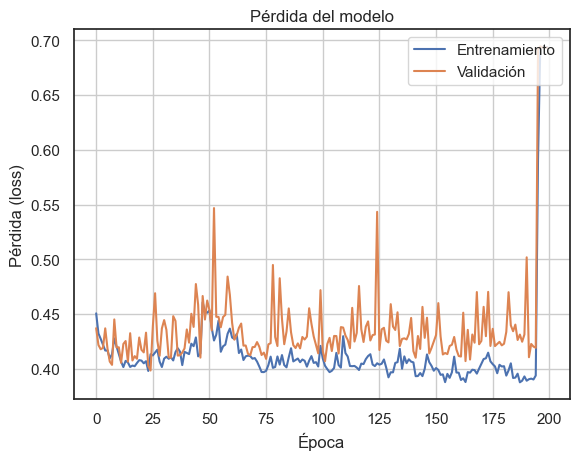

In [117]:
# Verificar que history contiene los datos esperados
print("Keys en history:", history.keys())

# Graficar pérdida de entrenamiento y validación
plt.plot(history['loss'], label='Entrenamiento')
plt.plot(history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida (loss)')
plt.xlabel('Época')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


## Usamos Optuna para optimizar los hiperparámetros de una red neuronal y evaluarla con métricas relevantes.

**Justificación del uso de Optuna**
- Optuna es más eficiente que el Grid Search y el Random Search porque utiliza métodos adaptativos para buscar en el espacio de hiperparámetros. Esto reduce significativamente el tiempo de cómputo y mejora los resultados.



### Optuna

In [118]:
import optuna
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Definimos una función objetivo para Optuna
def objective(trial):
    # Hiperparámetros a optimizar
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    neurons_layer1 = trial.suggest_int('neurons_layer1', 16, 128, step=16)
    neurons_layer2 = trial.suggest_int('neurons_layer2', 8, 64, step=8)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    
    # Regularización
    l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-2)  # Regularización L2
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)  # Tasa de Dropout

    # Crear modelo dinámico según los hiperparámetros
    model = tf.keras.Sequential()
    
    # Capa de entrada con regularización L2
    model.add(tf.keras.layers.Dense(neurons_layer1, activation='relu', 
                                    input_shape=(X_train_scaled.shape[1],),
                                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    
    # Agregar capas ocultas con regularización L2 y Dropout
    for _ in range(num_layers - 1):
        model.add(tf.keras.layers.Dense(neurons_layer2, activation='relu', 
                                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        if dropout_rate > 0.0:
            model.add(tf.keras.layers.Dropout(dropout_rate))  # Capa Dropout para regularización
    
    # Capa de salida
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compilación del modelo
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Entrenamiento
    X_train_fold, X_valid_fold, y_train_fold, y_valid_fold = train_test_split(
        X_train_scaled, y_train, test_size=0.2, random_state=42)
    
    history = model.fit(X_train_fold, y_train_fold,
                        validation_data=(X_valid_fold, y_valid_fold),
                        epochs=50,  # Número fijo de épocas
                        batch_size=batch_size,
                        verbose=0)
    
    # Evaluación
    _, val_accuracy = model.evaluate(X_valid_fold, y_valid_fold, verbose=0)
    return val_accuracy

# Crear un estudio y optimizar
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Mejor conjunto de hiperparámetros
print("Mejores hiperparámetros:", study.best_params)
print("Mejor precisión en validación:", study.best_value)


[I 2024-11-28 10:52:08,305] A new study created in memory with name: no-name-d29c3c5e-00e5-4e0c-960b-00f1c9b99cb7
C:\Users\brisa\AppData\Local\Temp\ipykernel_17628\792829932.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
C:\Users\brisa\AppData\Local\Temp\ipykernel_17628\792829932.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-2)  # Regularización L2
C:\Users\brisa\AppData\Local\Temp\ipykernel_17628\792829932.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/

Mejores hiperparámetros: {'learning_rate': 0.0014320096213793273, 'neurons_layer1': 112, 'neurons_layer2': 64, 'batch_size': 128, 'num_layers': 2, 'l2_reg': 6.5615237491701726e-06, 'dropout_rate': 0.19833507655360078}
Mejor precisión en validación: 0.8599134087562561


### Modelo con los hiperparametros optimizados

Epoch 1/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7598 - loss: 0.4904 - val_accuracy: 0.8070 - val_loss: 0.4182
Epoch 2/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8079 - loss: 0.4159 - val_accuracy: 0.8111 - val_loss: 0.4079
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8154 - loss: 0.4011 - val_accuracy: 0.8165 - val_loss: 0.3992
Epoch 4/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8260 - loss: 0.3890 - val_accuracy: 0.8229 - val_loss: 0.3906
Epoch 5/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8329 - loss: 0.3779 - val_accuracy: 0.8233 - val_loss: 0.3902
Epoch 6/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8350 - loss: 0.3721 - val_accuracy: 0.8220 - val_loss: 0.3898
Epoch 7/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8372 - loss: 0.3685 - val_accuracy: 0.8269 - val_loss: 0.3827
Epoch 8/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8446 - loss: 0.3546 - val_accuracy: 0.

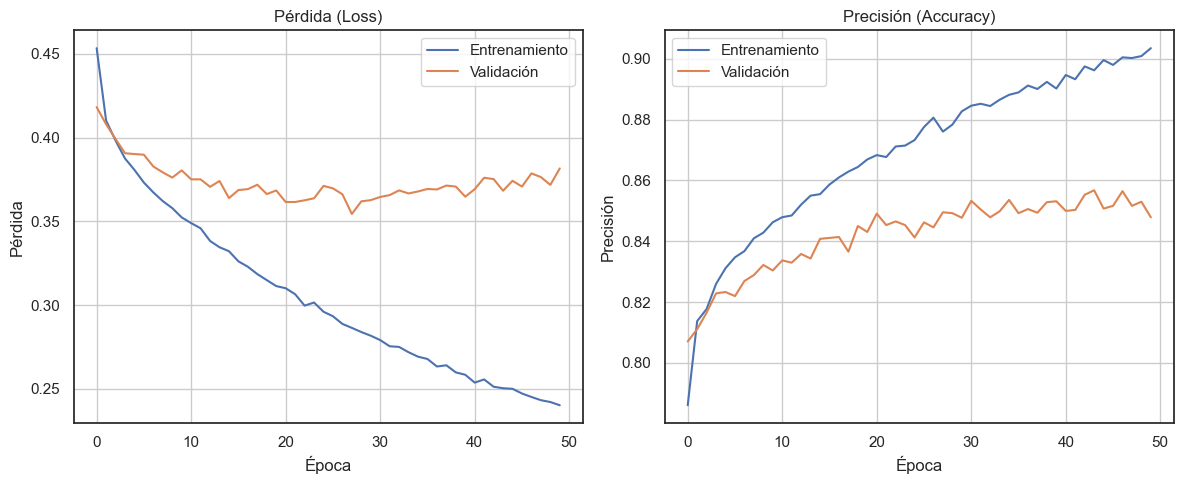

In [119]:
# Obtener los mejores hiperparámetros
best_params = study.best_params

# Crear el modelo final con los mejores hiperparámetros
final_model = tf.keras.Sequential()

# Capa de entrada con regularización L2
final_model.add(tf.keras.layers.Dense(
    best_params['neurons_layer1'], 
    activation='relu', 
    input_shape=(X_train_scaled.shape[1],),
    kernel_regularizer=tf.keras.regularizers.l2(best_params['l2_reg'])
))

# Agregar capas ocultas con regularización L2 y Dropout
for _ in range(best_params['num_layers'] - 1):
    final_model.add(tf.keras.layers.Dense(
        best_params['neurons_layer2'], 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(best_params['l2_reg'])
    ))
    if best_params['dropout_rate'] > 0.0:
        final_model.add(tf.keras.layers.Dropout(best_params['dropout_rate']))

# Capa de salida
final_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compilar el modelo
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Entrenar el modelo con todos los datos de entrenamiento
history = final_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_valid_scaled, y_valid),
    epochs=50,  # Puedes ajustar este número
    batch_size=best_params['batch_size'],
    verbose=1
)

# Evaluar el modelo final en el conjunto de prueba
final_accuracy = final_model.evaluate(X_test_scaled, y_test, verbose=1)[1]
print("\n--- Modelo Final ---")
print(f"Precisión en el conjunto de prueba: {final_accuracy:.4f}")

# Opcional: Graficar la pérdida y precisión del modelo final
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Gráfico de la precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión (Accuracy)')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [120]:
from sklearn.metrics import f1_score

# Realizar predicciones en el conjunto de prueba
y_pred_probs = final_model.predict(X_test_scaled)  # Predicciones como probabilidades
y_pred = (y_pred_probs > 0.5).astype(int)          # Convertir probabilidades a clases (umbral 0.5)

# Calcular el F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score en el conjunto de prueba: {f1:.4f}")


174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
F1-score en el conjunto de prueba: 0.6251


### Justificación del código y de los hiperparámetros optimizados




En este código, se utiliza **Optuna** para optimizar los hiperparámetros de una red neuronal creada con **TensorFlow**. El objetivo es encontrar el conjunto de hiperparámetros que maximice la precisión del modelo en un conjunto de validación.

- Hiperparámetros optimizados:

1. **learning_rate**: La tasa de aprendizaje controla cómo de grandes son las actualizaciones de los pesos en cada paso del entrenamiento. Un valor adecuado es crucial para la convergencia del modelo sin causar inestabilidad ni un aprendizaje demasiado lento.
   
2. **neurons_layer1 y neurons_layer2**: El número de neuronas en las capas ocultas determina la capacidad del modelo para aprender patrones complejos. Si se elige un número muy bajo, el modelo será incapaz de aprender adecuadamente, mientras que un número muy alto puede llevar a sobreajuste.

3. **batch_size**: El tamaño del lote afecta la velocidad de entrenamiento y la estabilidad del modelo. Batches pequeños pueden hacer que el modelo se entrene más rápido pero con más ruido en las actualizaciones, mientras que batches grandes son más estables pero más lentos.

4. **num_layers**: El número de capas ocultas controla la profundidad del modelo. Más capas permiten aprender representaciones más complejas, pero también incrementan el riesgo de sobreajuste.

5. **l2_reg**: La regularización L2 ayuda a evitar que los pesos se vuelvan demasiado grandes, lo cual podría causar sobreajuste. La optimización de este parámetro ajusta la penalización sobre los pesos grandes.

6. **dropout_rate**: La tasa de Dropout desactiva aleatoriamente algunas neuronas durante el entrenamiento para evitar sobreajuste. Este parámetro es optimizado para encontrar la tasa de Dropout más efectiva para la generalización del modelo.

Estos hiperparámetros son fundamentales para ajustar la complejidad y la capacidad de generalización del modelo, permitiendo que se adapte mejor a los datos sin sobreajustarse a ellos. La optimización mediante **Optuna** facilita la búsqueda del mejor conjunto de estos parámetros.

## Shap Redes

**Justificación del uso de SHAP**
- SHAP explica las predicciones en términos de contribuciones de cada característica. Esto es esencial para entender cómo el modelo toma decisiones.

#### Explicabilidad local

In [123]:
import shap
import numpy as np

# Asegúrate de convertir el background a numpy.ndarray
background = x_train.sample(100).to_numpy()

# Crea una función callable para el modelo
def model_callable(X):
    return model.predict_proba(X)[:, 1]  # Si necesitas probabilidades para clases específicas

# Crear el objeto explainer SHAP utilizando KernelExplainer
explainer = shap.KernelExplainer(model_callable, background)


c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [124]:


instance_to_explain = x_test.iloc[0:1].values  # Seleccionar la línea 0

# Calcular los valores SHAP para los datos de prueba
shap_values = explainer.shap_values(instance_to_explain)

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


In [125]:

# Obtener el valor esperado (base value)
expected_value = explainer.expected_value

# Hacer predicciones
index = 0  # índice de la instancia que queremos explicar
predicted_proba = model.predict(x_test)[index]  # Predicción de probabilidad
predicted_class = np.argmax(predicted_proba)  # Clase predicha

In [126]:
import shap
import numpy as np

# Asegúrate de utilizar el método adecuado para generar shap_values
explainer = shap.Explainer(model, x_train)

# Verificar el tipo de datos de shap_values
print("Type of shap_values:", type(shap_values))

# Verificar la forma de shap_values para asegurarte de que sea correcta
if isinstance(shap_values, np.ndarray):
    print("Shape of shap_values:", shap_values.shape)
else:
    print("Error: shap_values no es un arreglo NumPy válido.")




Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values: (1, 26)


Por lo tanto, el shape (3639, 26) indica que para cada una de las 3639 muestras, se están calculando los valores SHAP para las 26 características del modelo. Estos valores muestran cómo cada característica contribuye a la predicción de cada muestra.

Shape of shap_values: (1, 26)
Shape of shap_values_single: (26,)


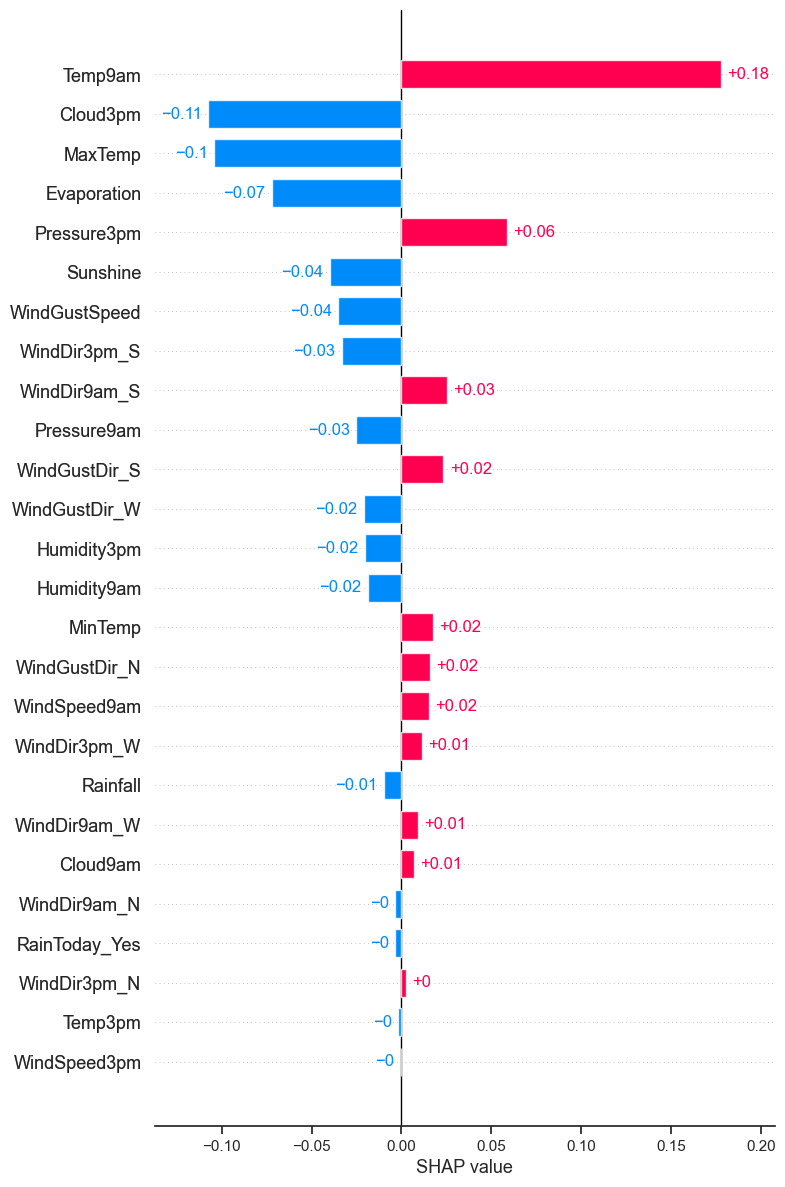

In [127]:
# Verificar la forma de shap_values
print("Shape of shap_values:", shap_values.shape)  # Salida: (1, 26, 1)

# Asegurarse de acceder correctamente a la primera instancia de explicación
shap_values_single = shap_values[0]

# Verificar la forma de shap_values_single para confirmar que ahora es (26, 1)
print("Shape of shap_values_single:", shap_values_single.shape)  # Salida: (26, 1)

# Crear la explicación para la instancia específica
explanation = shap.Explanation(values=shap_values_single, base_values=expected_value, feature_names=feature_names)

# Visualizar la explicación de las importancias de las características usando shap.plots.bar
shap.initjs()
shap.plots.bar(explanation, max_display=len(feature_names))

#### Explicabilidad global


In [128]:
import shap

# Seleccionar una única instancia para explicar
instance_to_explain = x_test.sample(n=1).values



PermutationExplainer explainer: 5557it [08:57, 10.25it/s]                          


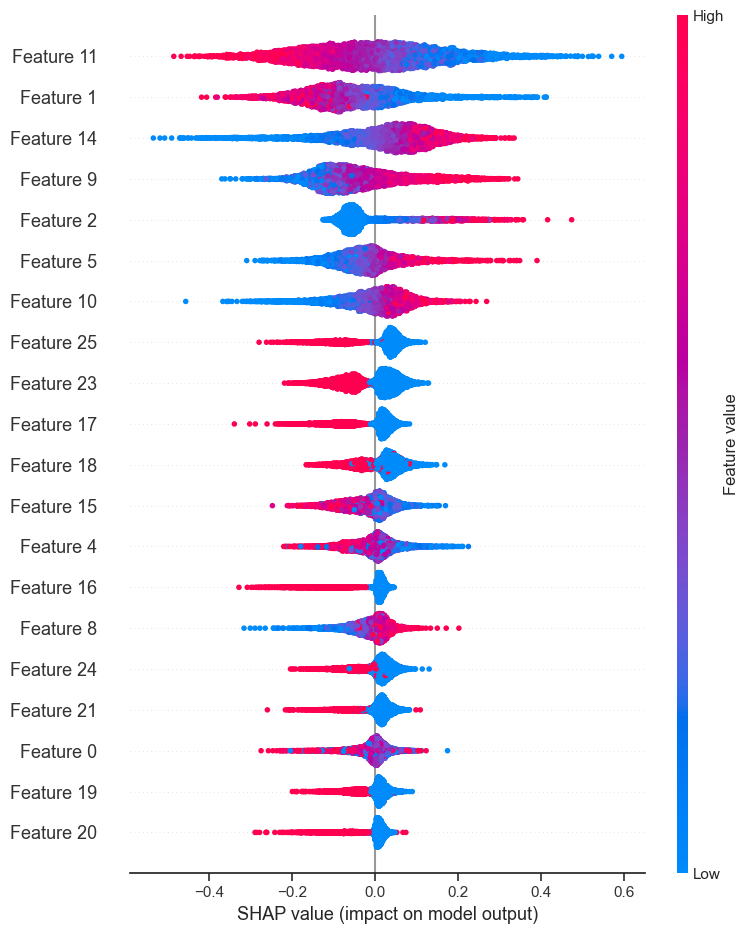

In [129]:
# Crear un explicador SHAP para el modelo
explainer = shap.Explainer(final_model, X_train_scaled)

# Calcular los valores SHAP para los datos de prueba
shap_values = explainer(X_test_scaled)
# Crear un objeto PermutationExplainer
#explainer = shap.Explainer(model, X_test_scaled, algorithm='permutation')

# Obtener los valores SHAP para el conjunto de prueba
#shap_values = explainer(x_test)

# Visualizar los valores SHAP
shap.summary_plot(shap_values, x_test)


Type of shap_values: <class 'shap._explanation.Explanation'>


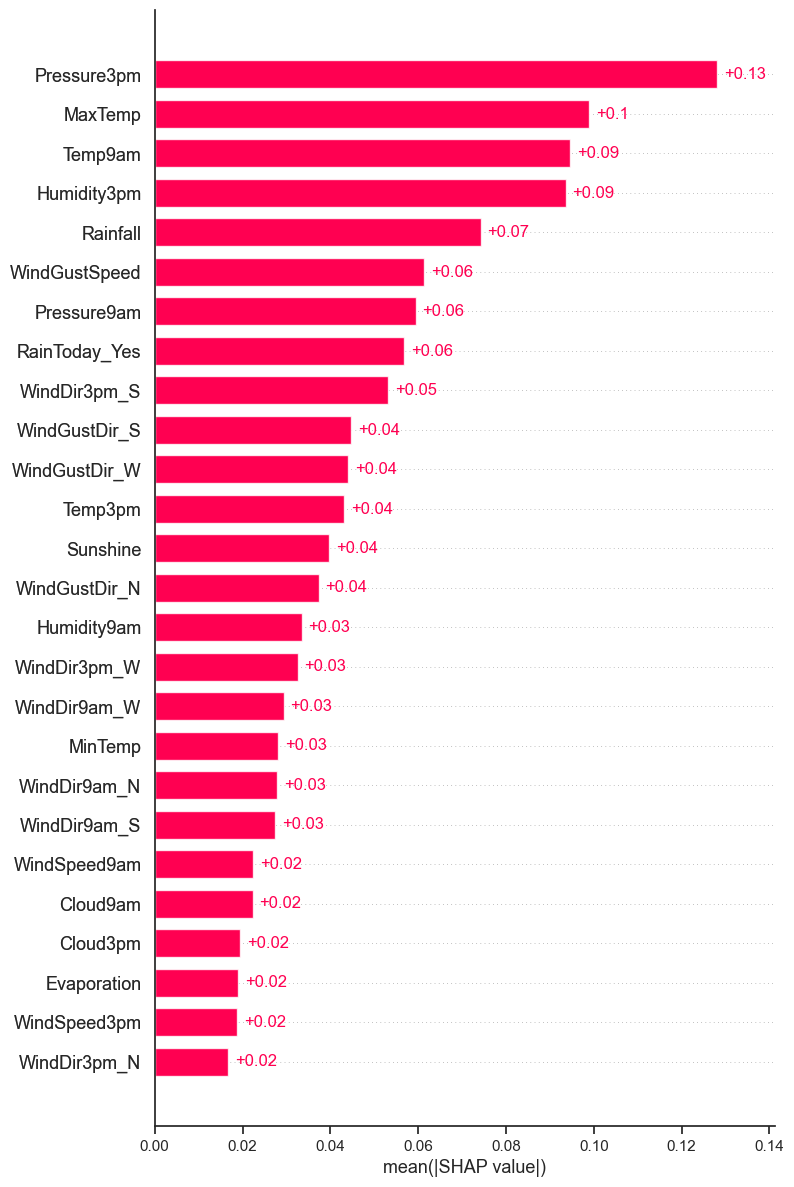

In [130]:

# Verificar el tipo de datos de shap_values
print("Type of shap_values:", type(shap_values))

# Crear la explicación para las importancias de las características globales
feature_names = x_test.columns  # Ajusta según sea necesario
explanation = shap.Explanation(values=shap_values.values, base_values=shap_values.base_values, data=x_test, feature_names=feature_names)

# Inicializar JS para gráficos interactivos si estás en Jupyter Notebook
shap.initjs()

# Visualizar la explicación de las importancias de las características usando shap.plots.bar
plt.figure(figsize=(12, 6))  # Ajusta el tamaño de la figura según sea necesario
shap.plots.bar(explanation, max_display=len(feature_names))

# Mostrar el gráfico
plt.show()


# Comparación de Modelos de Clasificación usando F1-score

| Modelo/Técnica | F1-score |
|----------------|----------|
| Modelo Base | 0.62  |
| Regresión Logística Inicial | 0.62 |
| Grid Search | 0.61 |
| Random Search | 0.61 |
| Optuna | 0.65 |
| AUTOML | 0.64 |
| Red Neuronal |  0.62 |

### Interpretación de Mis Resultados

- **Optuna y AutoML** fueron las técnicas más efectivas, superando al modelo base y a los métodos tradicionales de ajuste. Esto destaca la importancia de enfoques modernos y automatizados en la optimización de hiperparámetros.
- La falta de mejoras significativas en las técnicas tradicionales (Grid y Random Search) podría indicar que los hiperparámetros seleccionados manualmente o el diseño inicial del modelo ya estaban cerca de un punto óptimo.
- El desempeño limitado de la red neuronal sugiere que la complejidad del modelo debe alinearse cuidadosamente con las características de los datos para evitar un impacto negativo en el rendimiento.
- Estos resultados enfatizan la importancia de elegir técnicas avanzadas para tareas de optimización complejas y la necesidad de una comprensión profunda del problema para ajustar modelos más sofisticados.